# Malware classification, a simple comparison:
## dynamic analysis features, text vectorizers, metrics and winning models

# intro

## TL;DR
This notebook takes cuckoo-sandbox reports and process them into long sentences builded from system-calls ('syscalls'). 

It then labels them according to VirusTotal ('VT') AVs results.

Then, we build features from the sentences using Frequency of Ngrams (we're using frequency method for simplicity reasons, we coul'd have used TF-IDF just as well).

We train different models on these features and compare simple metrics and curves, and lastly announcing winning classifiers. 


## אמ;לק
מחברת שמעבדת דוחות קוקו, והופכת אותם למשפטים ארוכים של סיסקולים עם לייבל מתאים מוירוס-טוטאל

לאחר מכן בונים מהמשפטים פיצ'רים באמצעות תדירות הופעה של אן-גרמים (באותה מידה אפשר גם לבצע -טי-אף-איי-די-אף)

ומריצים מודלים קלאסיים ואחרים (לוגיסטיק-רגרשן / רנדום-פורסט)

לבסוף אנחנו משווים מטריקות וגרפים ומכריזים על מסווגים מנצחים


## Dataset

We're using a fraction from The Berkeley Detection Platform, a malware-dataset containing over 1 million samples collected over a period of 2.5 years.

http://secml.cs.berkeley.edu/detection_platform/


### project imports

In [1]:
#### project imports

# basis
import os
import json
import sys
import itertools
from pathlib import Path
import pandas
import numpy

# feature_extraction
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# models
from sklearn import linear_model
from sklearn import  ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# metrics and curves
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# nir added for sort-by-timestamp
from datetime import datetime


### setting pathes for data directory 

In [2]:
# TODO: set data dir 
cuckoo_reports_dir_Path = Path("/home/john/Desktop/SCNN/IGNORE/miller700_150_ratio_train50_test10/")
labels_dict_Path = Path("/home/john/Desktop/SCLR/IGNORE/miller700_150_ratio05/labels.json")
!file /home/john/Desktop/SCLR/IGNORE/miller700_150_ratio05/test/0009e4770ea519865c55e9e8dff5c9a537740761a14e8aac3c69bb7d47a92115

/home/john/Desktop/SCLR/IGNORE/miller700_150_ratio05/test/0009e4770ea519865c55e9e8dff5c9a537740761a14e8aac3c69bb7d47a92115: ASCII text, with very long lines, with no line terminators


## load syscalls data 

### for each cuckoo report, sort syscalls (from all processes) by timestamps, and create a sentece from the first 'max_seq_len'.

In [3]:
max_seq_len = 500  # lowest limit = 500
i=0
labels = {}
processed_sequences = {}

with open(labels_dict_Path, 'rb') as labels_dict_handle:
    labels_dict = json.load(labels_dict_handle)

    
for set in ["train", "test"]:
    labels[set] = []
    processed_sequences[set] = []
    for report_file in os.listdir(cuckoo_reports_dir_Path/set):
        i=i+1
        with open(file=cuckoo_reports_dir_Path/set/report_file, mode='r', encoding="latin-1") as report_file_handle: # deleted 'rb'
            try:
                report_data = json.load(report_file_handle)

                # extract sorted calls by time:
                calls_times_dict = {}
                procs_list = report_data['behavior']['processes']
                extracted_procs_dict_list = []
                for proc_dict in procs_list:
                    calls_list = proc_dict["calls"]
                    extracted_proc_dict_list = []
                    for call_dict in itertools.islice(calls_list, 0, max_seq_len):
                        timestamp_str = call_dict['timestamp']
                        date_time_obj = datetime.strptime(timestamp_str, '%Y%m%d%H%M%S.%f')
                        syscall_str = call_dict['api']
                        extracted_calls_times_dict = {}
                        extracted_calls_times_dict['date_time_obj'] = date_time_obj
                        extracted_calls_times_dict['syscall_str'] = syscall_str
                        extracted_proc_dict_list.append(extracted_calls_times_dict)
                    extracted_procs_dict_list.extend(extracted_proc_dict_list)
                extracted_procs_dict_list = sorted(extracted_procs_dict_list,
                                                       key=lambda call: call['date_time_obj'],
                                                       reverse=False)[0:max_seq_len]
                seq_sentence = ' '.join(d['syscall_str'] for d in extracted_procs_dict_list)
                processed_sequences[set].append(seq_sentence)

                # extract label for this sample (only if no excep occured):
                sha256 = report_data['sha256']
                score = numpy.float64(labels_dict[sha256]['score'])
                syscalls_label = 1 if score > 5 else 0
                labels[set].append(syscalls_label)

            except json.JSONDecodeError as err:
                print("process report {0}   JSONDecodeError error: {1}".format(report_file, err))
                pass
            except:
                print("process_reports_file: {0}, error: {1}".format(report_file, sys.exc_info()))
                pass


process_reports_file: c4b75fdc16cae23c4598dd770a586687e1c50501a4da4c20c43060ea0ec12119, error: (<class 'ValueError'>, ValueError('time data \'6cae23c4598dd770a586687e1c50501a4da4c20c43060ea0ec12119"\' does not match format \'%Y%m%d%H%M%S.%f\''), <traceback object at 0x7f99480b30f0>)


In [4]:
processed_sequences["train"][0][0:100]

'CreateFileW ReadFile ReadFile CreateFileW WriteFile ReadFile WriteFile CreateFileW CreateFileW ReadF'

In [5]:
len(processed_sequences["train"])

699

In [6]:
len(processed_sequences["test"])

146

#### convert data to pandas.DataFrame

In [7]:
trainDF = pandas.DataFrame()
trainDF['text'] = processed_sequences["train"]
trainDF['label'] = labels["train"]
train_x, train_y = trainDF['text'], trainDF['label']

testDF = pandas.DataFrame()
testDF['text'] = processed_sequences["test"]
testDF['label'] = labels["test"]
test_x, test_y = testDF['text'], testDF['label']

# counting #differents syscalls in the data

In [8]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1))
cv_fit = count_vect.fit_transform(train_x)
print(count_vect.get_feature_names()[0:10])
print(len(count_vect.get_feature_names()))

['controlservice', 'copyfileexw', 'createfilew', 'createmutexw', 'createprocessinternalw', 'createremotethread', 'createservicea', 'deletefilew', 'deleteservice', 'deviceiocontrol']
42


In [9]:
itidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1))
itidf_fit = itidf_vect.fit_transform(train_x)
print(itidf_vect.get_feature_names()[0:10])
print(len(itidf_vect.get_feature_names()))

['controlservice', 'copyfileexw', 'createfilew', 'createmutexw', 'createprocessinternalw', 'createremotethread', 'createservicea', 'deletefilew', 'deleteservice', 'deviceiocontrol']
42


## build model and features with sklearn 


#### declare func: Train model, calc metrics and build ROC and P@R curves on Test set

In [10]:
def train_test_model(model, model_name, trainX, trainy, testX, testy, is_neural_net=False):
    
    # fit the training dataset on the classifier
    model.fit(trainX, trainy)
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_PR_f1, lr_PR_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    
    # nir added metricsPR-
    acc = accuracy_score(testy, yhat)
    precision, recall, ROC_auc = precision_score(testy, yhat), recall_score(testy, yhat), roc_auc_score(testy, lr_probs)
    # summarize scores
    print('\t Model: precision=%.3f recall=%.3f ROC-auc=%.3f accuracy=%.3f P@R-f1=%.3f P@R-auc=%.3f' % (precision, recall, ROC_auc, acc, lr_PR_f1, lr_PR_auc))
    
    # create 2 plots:
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    axes[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    axes[0].plot(lr_recall, lr_precision, marker='.', label='Model')
    # set title
    axes[0].set_title('Precision@Recall-Curve ('+model_name+')')
    # axis labels
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    # show the legend
    axes[0].legend()    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('\t No Skill: ROC AUC=%.3f' % (ns_auc))
    print('\t Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    axes[1].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    axes[1].plot(lr_fpr, lr_tpr, marker='.', label='Model')
    # set title
    axes[1].set_title('ROC-curve ('+model_name+')')
    # axis labels
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    # show the legend
    axes[1].legend()

    ret = {}
    ret['model'] = model_name
    ret['precision'] = precision
    ret['recall'] = recall
    ret['ROC_auc'] = ROC_auc
    ret['acc'] = acc
    ret['lr_PR_f1'] = lr_PR_f1
    ret['lr_PR_auc'] = lr_PR_auc
    ret['ns_auc'] = ns_auc
    ret['lr_auc'] = lr_auc
    
    return ret 

## comparing the calssifiers:
### Scikit-learn built-in models with Ngram from the syscalls sequences

In [11]:
# suppressing warnings for pretty prints
import warnings
warnings.filterwarnings("ignore")

In [12]:
n = 4
ngrams_dict_list = []
for i in range(1, n+1):
    for j in range(1, i+1):
        ngram = (j,i)
        ngram_name = str(ngram)+'-Grams'
        ngrams_dict_list.append((ngram, ngram_name))

In [13]:
# there are some commented models 
# that doesn't accept "new-syscalls" 
# which didn't appeared in the train-set
models_and_names_list = [(linear_model.LogisticRegression(), "LR"), \
                         (ensemble.RandomForestClassifier(), "RF"), \
                         (KNeighborsClassifier(3), "3 Nearest Neighbors"), \
                         (DecisionTreeClassifier(max_depth=5), "Decision Tree"), \
                         (RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), "10 Random Forest 5-max-depth"), \
                         (MLPClassifier(alpha=1, max_iter=1000), "Neural Net"), \
                         (AdaBoostClassifier(), "AdaBoost"), \
                         #(SVC(kernel="linear", C=0.025), "Linear SVM"), \
                         #(SVC(gamma=2, C=1), "RBF SVM"), \
                         #(GaussianProcessClassifier(1.0 * RBF(1.0)), "Gaussian Process"), \
                         #(GaussianNB(), "Gaussian Naive Bayes"), \
                         #(QuadraticDiscriminantAnalysis(), "QDA")
                        ]

In [14]:
vectorizers_and_names_list = [(CountVectorizer, "CountVectorizer"), \
                              (TfidfVectorizer, "TfidfVectorizer")]

model: LR with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.250 recall=0.615 ROC-auc=0.757 accuracy=0.801 P@R-f1=0.356 P@R-auc=0.528
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.757
model: RF with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.346 recall=0.692 ROC-auc=0.844 accuracy=0.856 P@R-f1=0.462 P@R-auc=0.581
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.844
model: 3 Nearest Neighbors with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.169 recall=0.769 ROC-auc=0.808 accuracy=0.644 P@R-f1=0.278 P@R-auc=0.475
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.808
model: Decision Tree with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.244 recall=0.846 ROC-auc=0.832 accuracy=0.753 P@R-f1=0.379 P@R-auc=0.346
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.832
model: 10 Random Forest 5-max-depth with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.209 recall=0.692 ROC-auc=0.860 accuracy=0.740 P@R-f1=0.321 P@R-auc=0

	 Model: precision=0.214 recall=0.692 ROC-auc=0.783 accuracy=0.747 P@R-f1=0.327 P@R-auc=0.516
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.783
model: AdaBoost with (2, 2)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.286 recall=0.769 ROC-auc=0.880 accuracy=0.808 P@R-f1=0.417 P@R-auc=0.691
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.880
model: LR with (1, 3)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.238 recall=0.769 ROC-auc=0.767 accuracy=0.760 P@R-f1=0.364 P@R-auc=0.552
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.767
model: RF with (1, 3)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.462 recall=0.923 ROC-auc=0.894 accuracy=0.897 P@R-f1=0.615 P@R-auc=0.603
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.894
model: 3 Nearest Neighbors with (1, 3)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.257 recall=0.692 ROC-auc=0.843 accuracy=0.795 P@R-f1=0.375 P@R-auc=0.495
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.843
model: Decision Tree with (1, 3)-G

	 Model: precision=0.152 recall=0.769 ROC-auc=0.689 accuracy=0.596 P@R-f1=0.253 P@R-auc=0.160
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.689
model: Neural Net with (3, 3)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.244 recall=0.769 ROC-auc=0.831 accuracy=0.767 P@R-f1=0.370 P@R-auc=0.557
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.831
model: AdaBoost with (3, 3)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.176 recall=0.692 ROC-auc=0.758 accuracy=0.685 P@R-f1=0.281 P@R-auc=0.212
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.758
model: LR with (1, 4)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.250 recall=0.769 ROC-auc=0.774 accuracy=0.774 P@R-f1=0.377 P@R-auc=0.672
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.774
model: RF with (1, 4)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.500 recall=0.692 ROC-auc=0.875 accuracy=0.911 P@R-f1=0.581 P@R-auc=0.549
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.875
model: 3 Nearest Neighbors with (1, 4)-Gram

	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.805
model: Decision Tree with (3, 4)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.278 recall=0.769 ROC-auc=0.773 accuracy=0.801 P@R-f1=0.408 P@R-auc=0.346
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.773
model: 10 Random Forest 5-max-depth with (3, 4)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.138 recall=0.692 ROC-auc=0.669 accuracy=0.589 P@R-f1=0.231 P@R-auc=0.245
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.669
model: Neural Net with (3, 4)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.233 recall=0.769 ROC-auc=0.850 accuracy=0.753 P@R-f1=0.357 P@R-auc=0.681
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.850
model: AdaBoost with (3, 4)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.279 recall=0.923 ROC-auc=0.857 accuracy=0.781 P@R-f1=0.429 P@R-auc=0.365
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.857
model: LR with (4, 4)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.273 recall=0.692 ROC-a

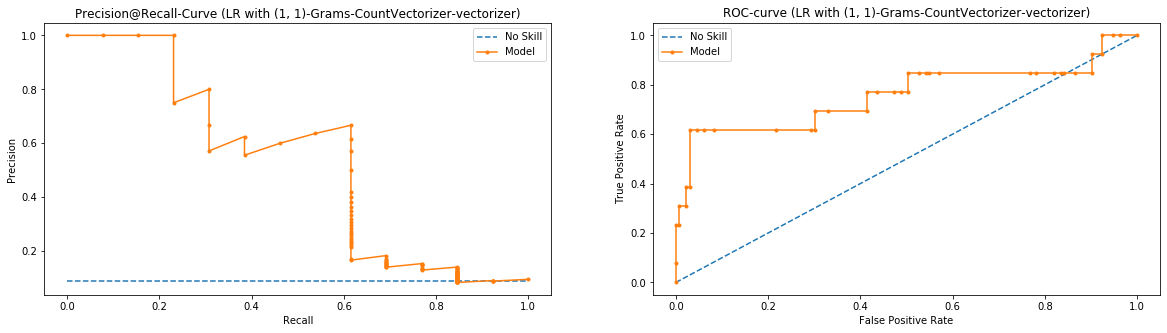

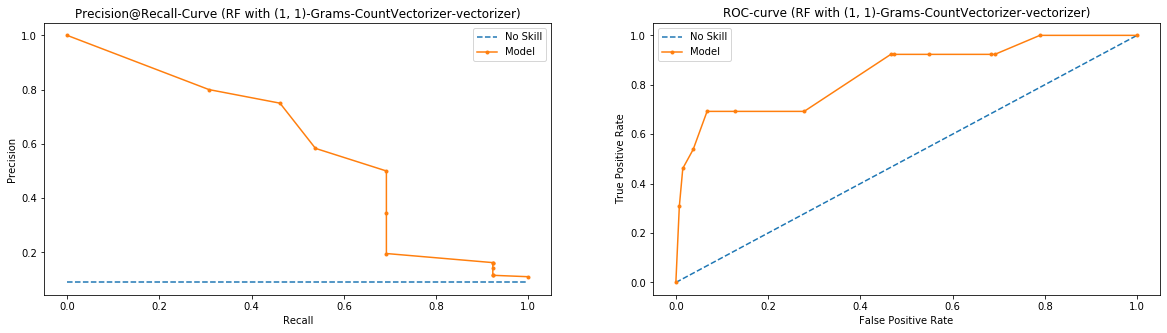

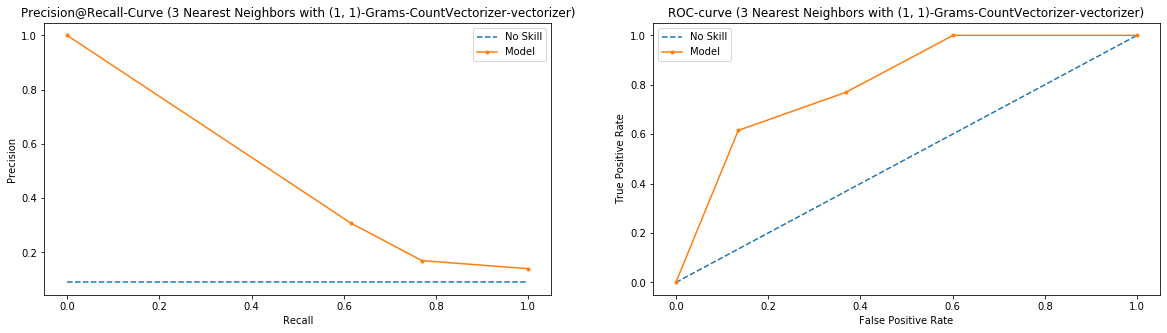

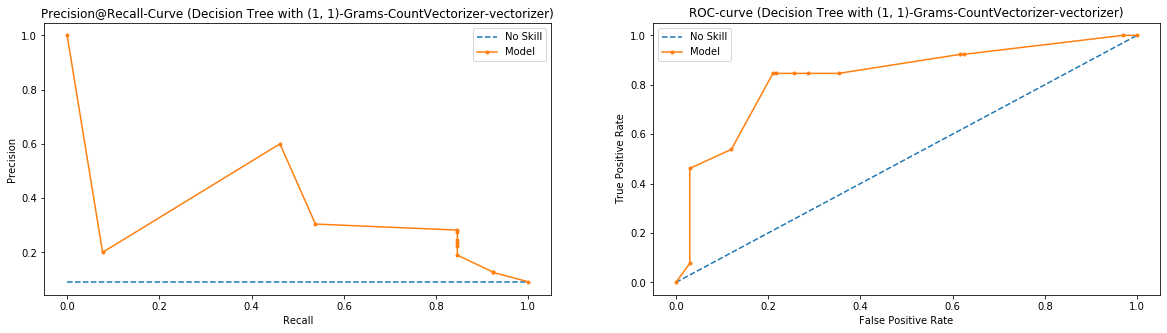

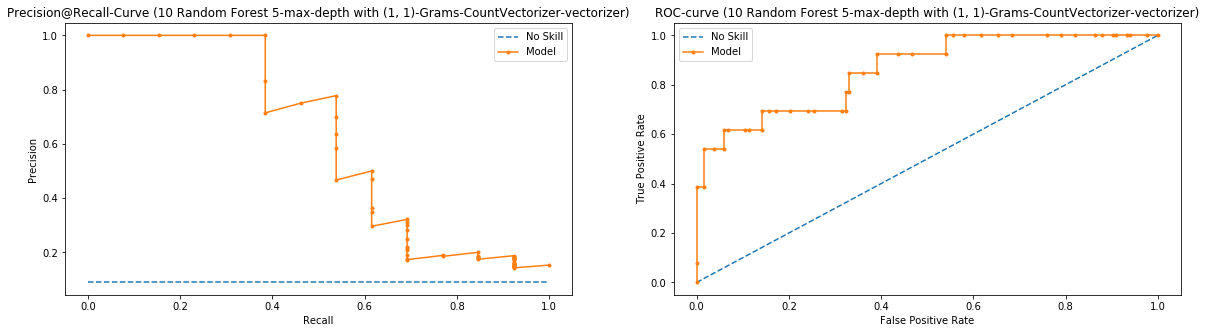

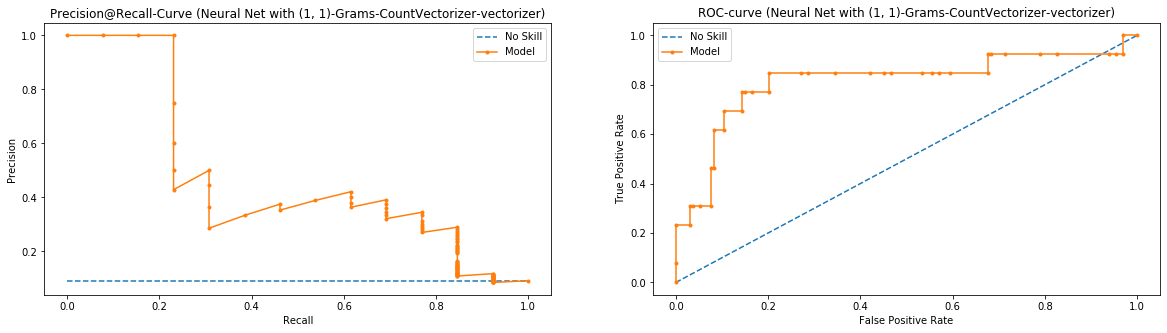

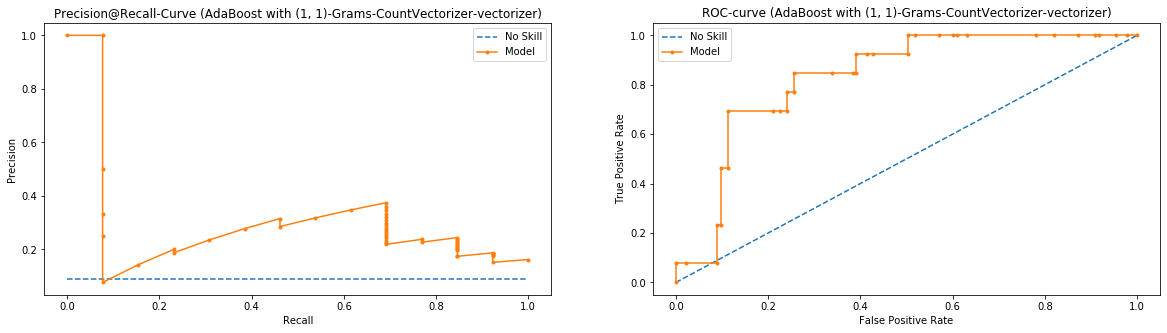

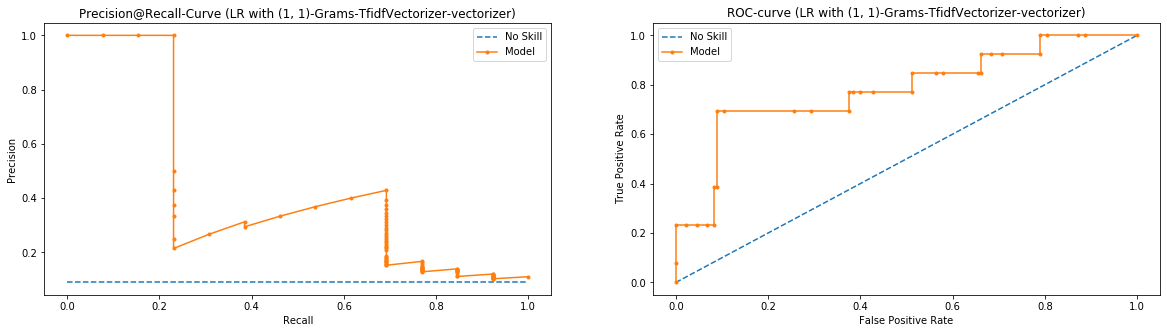

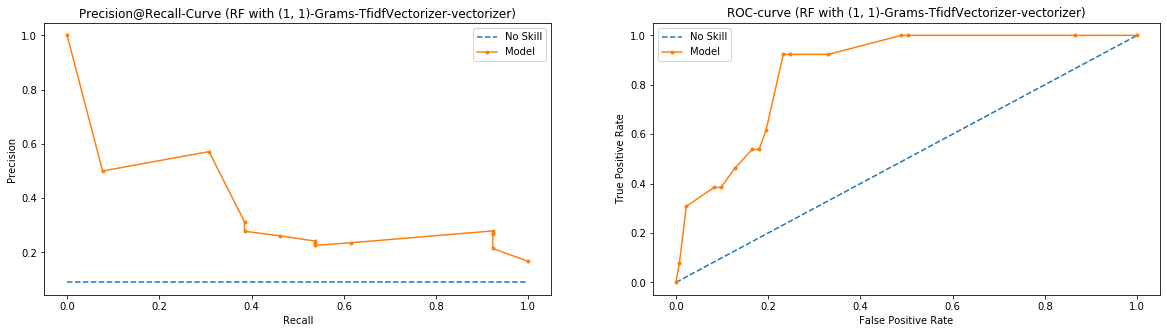

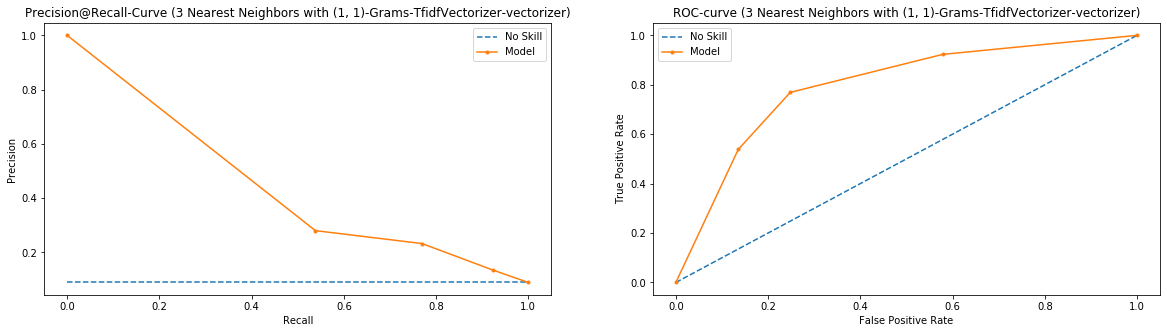

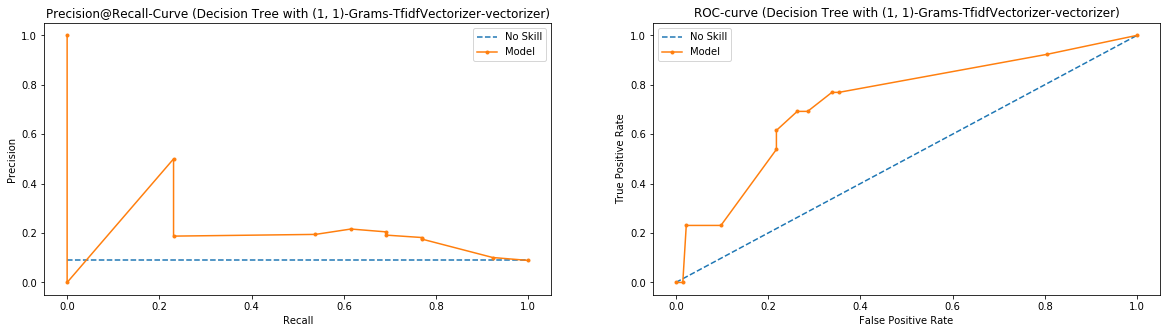

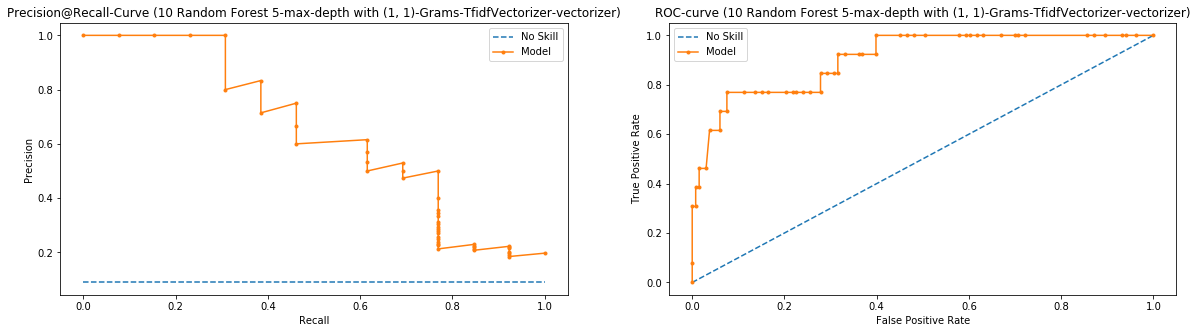

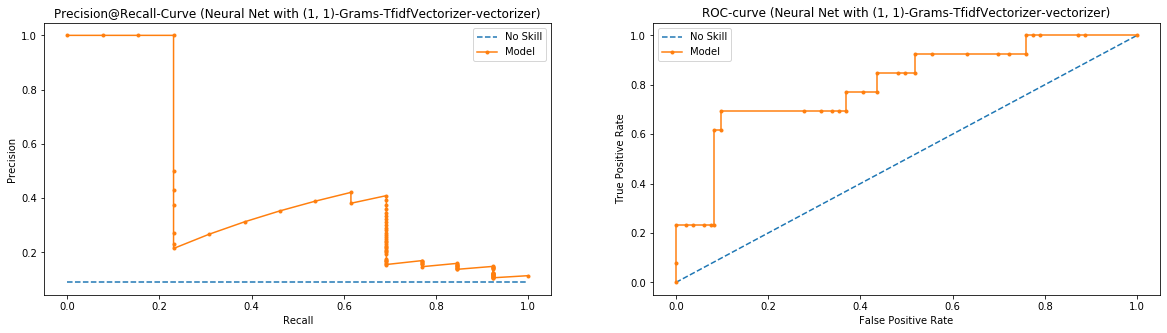

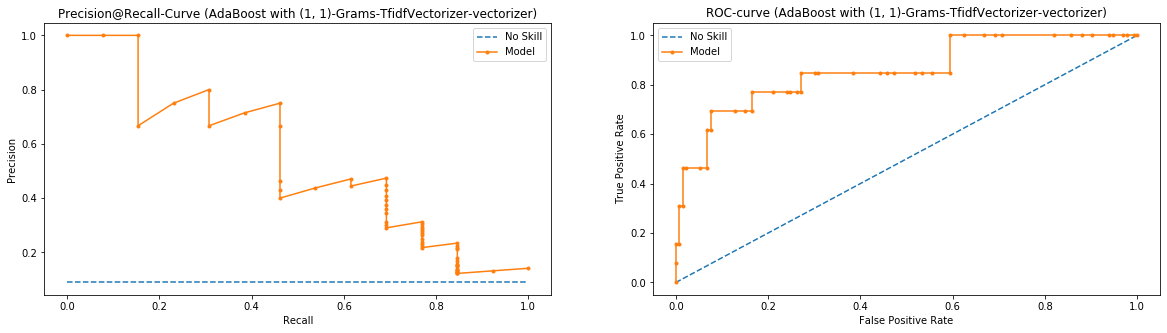

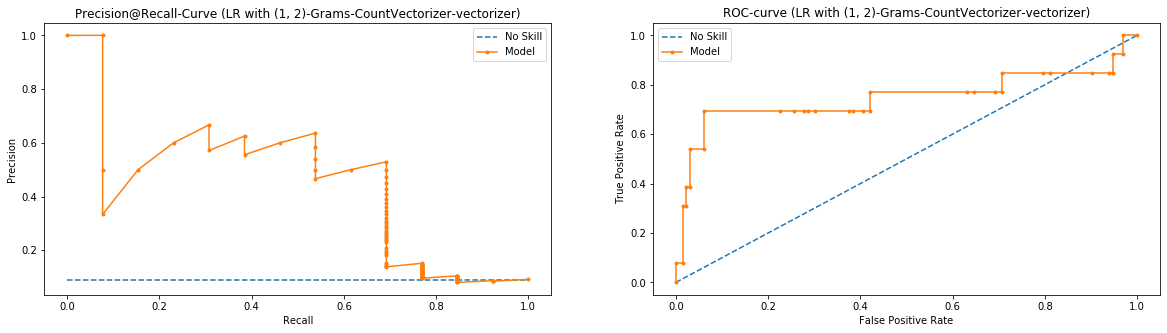

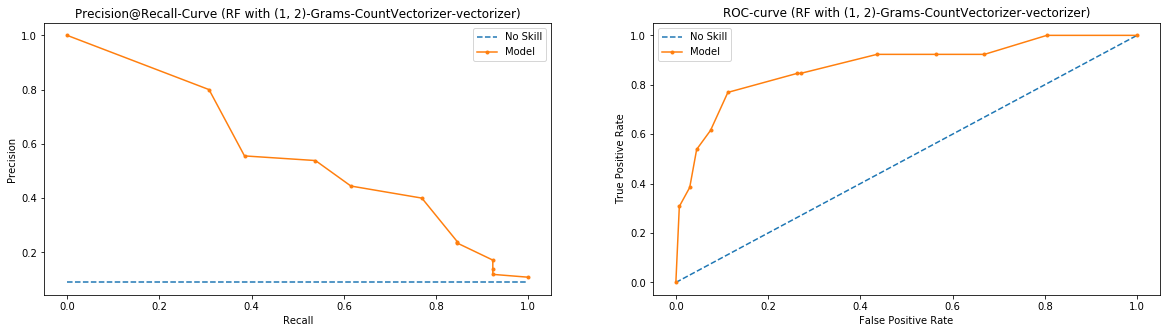

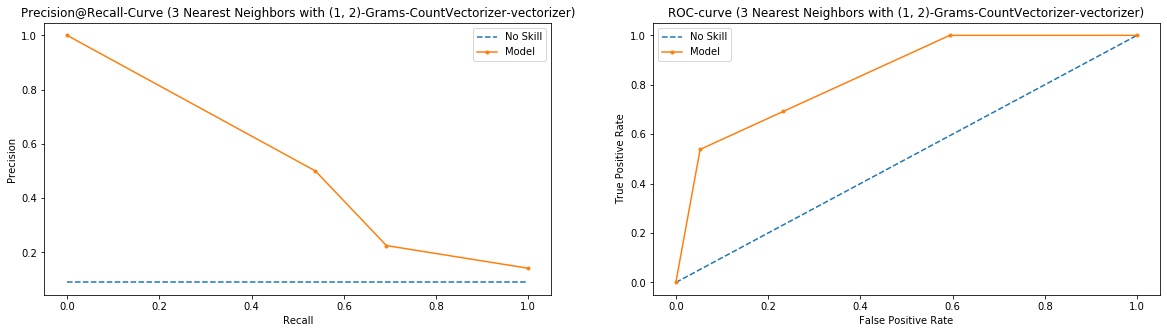

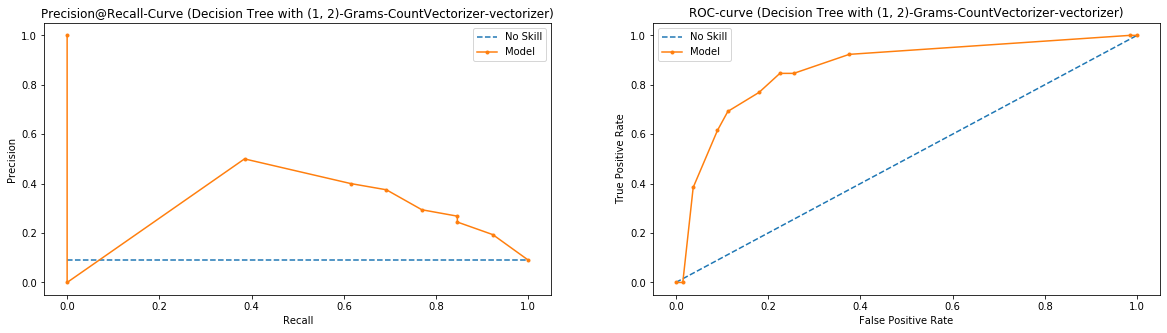

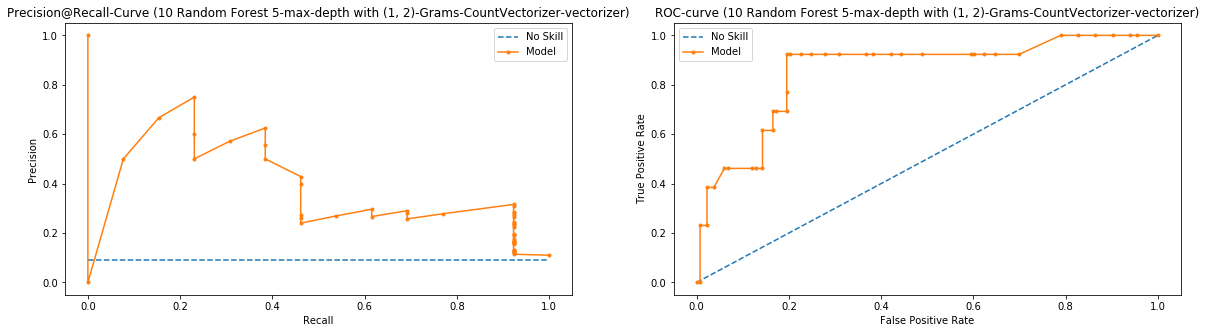

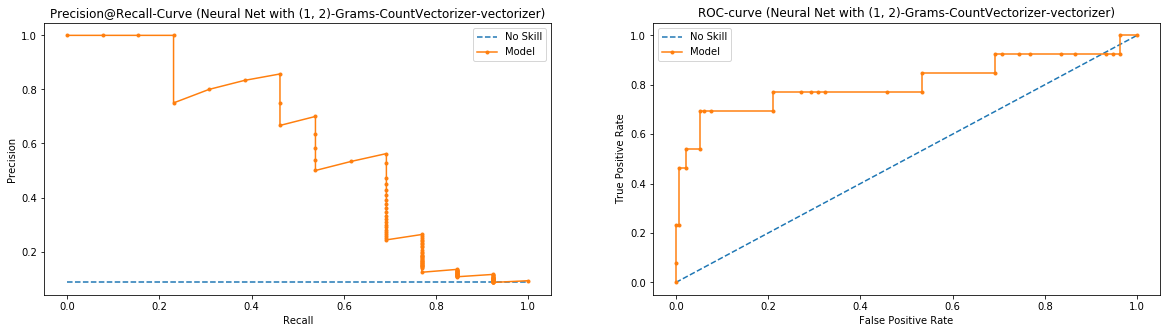

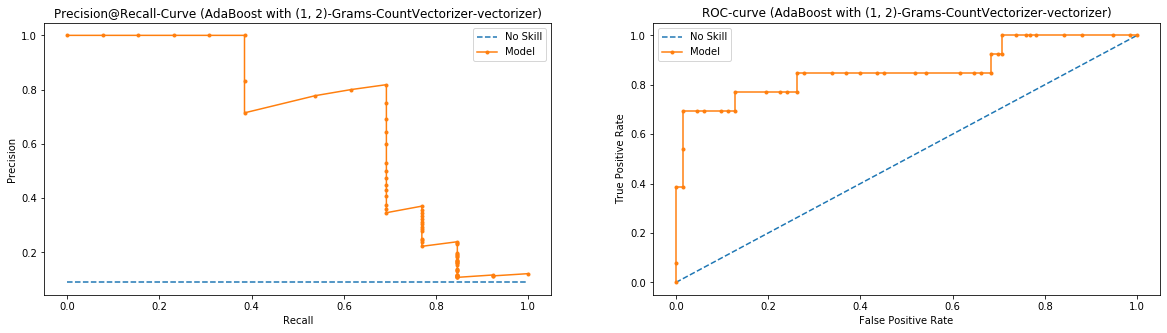

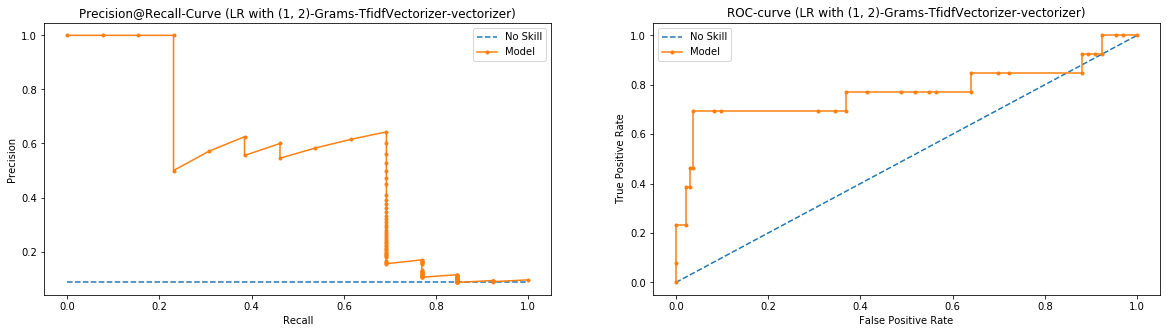

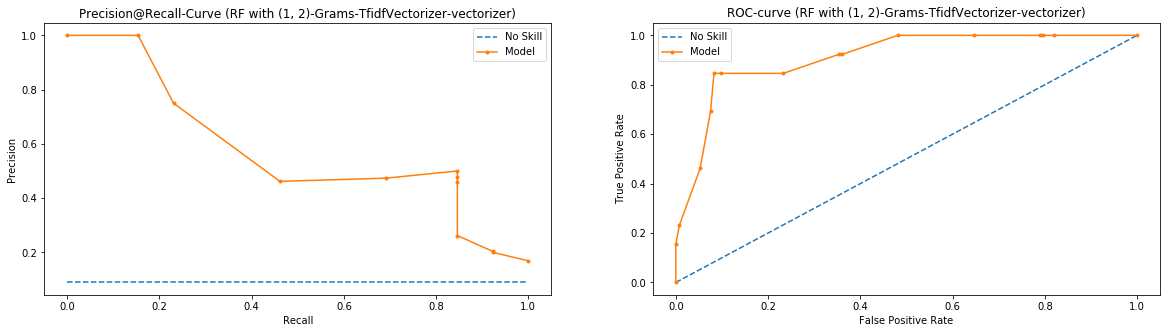

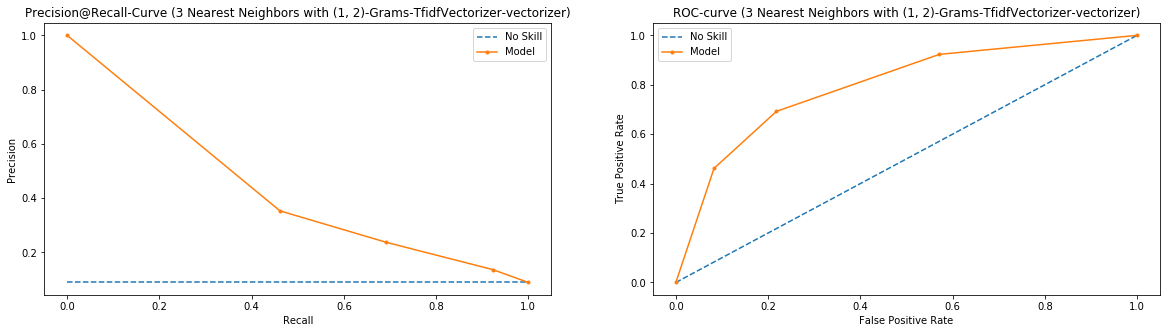

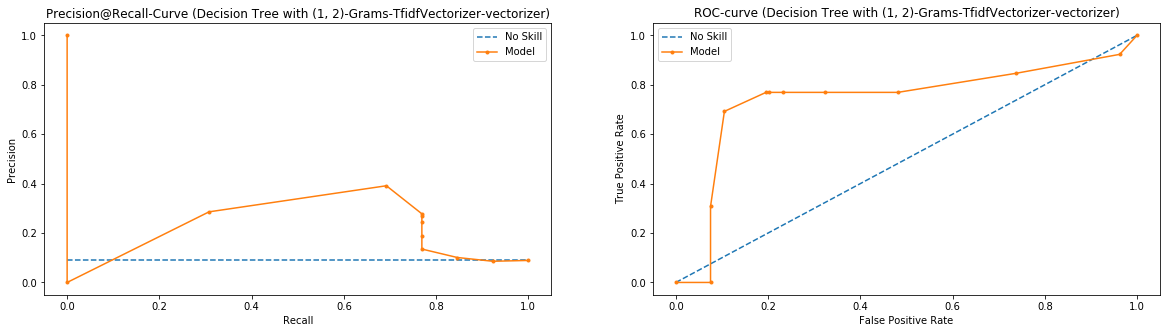

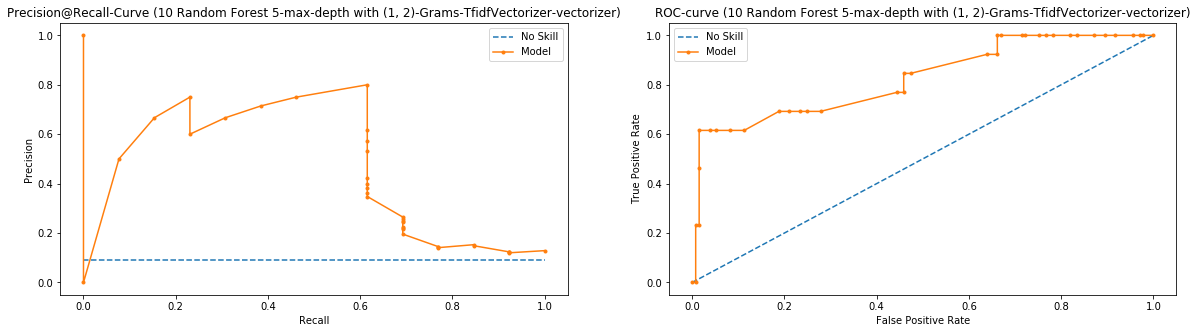

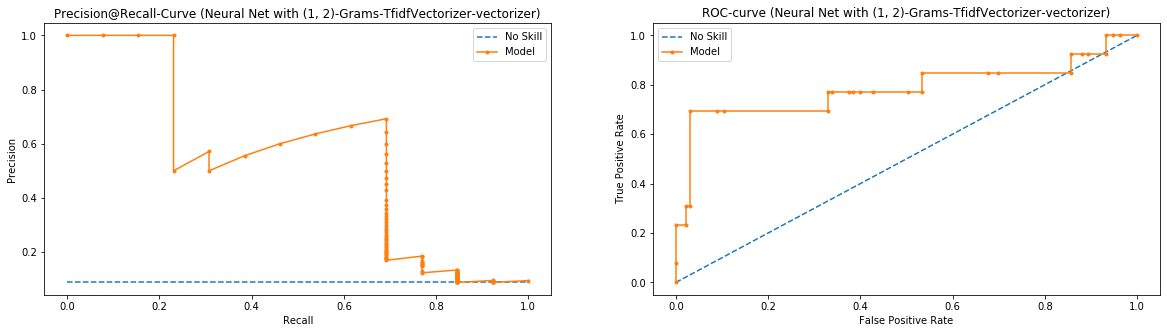

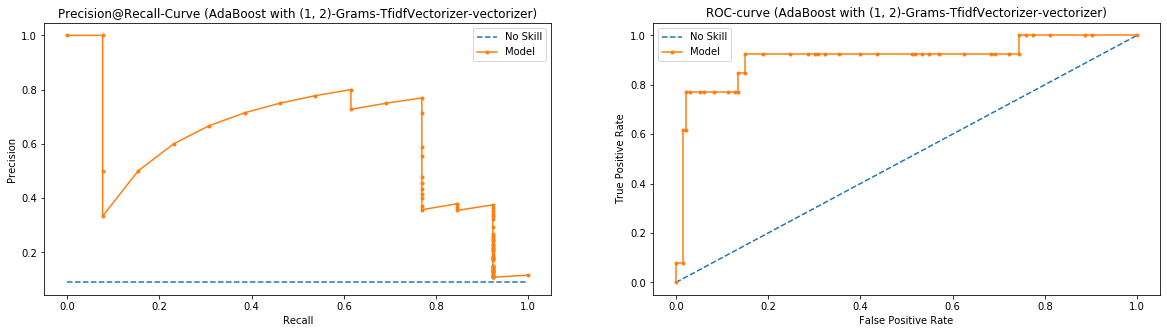

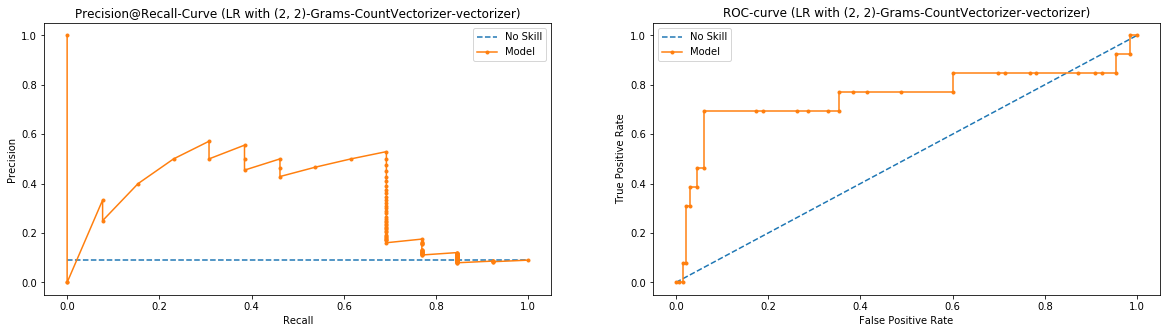

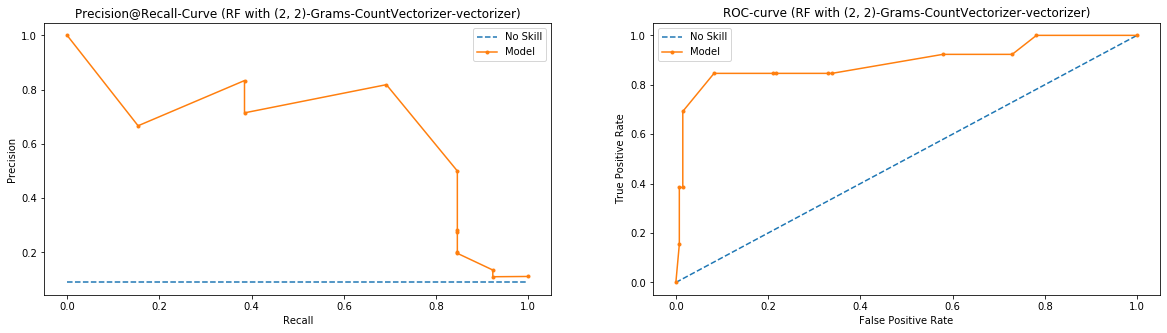

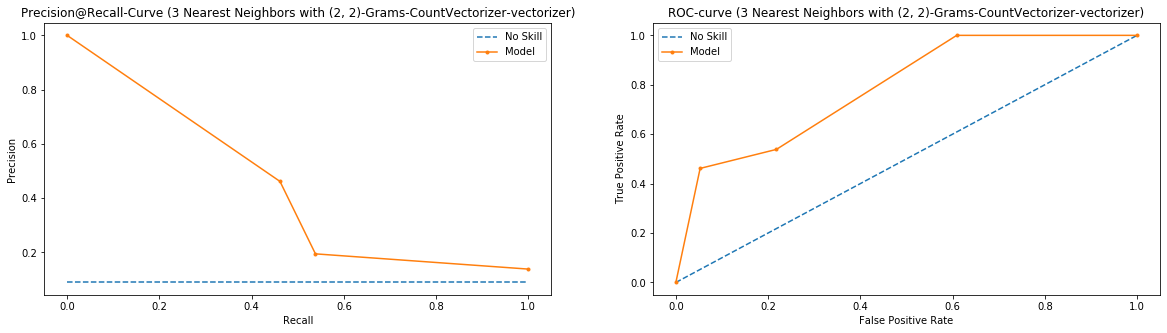

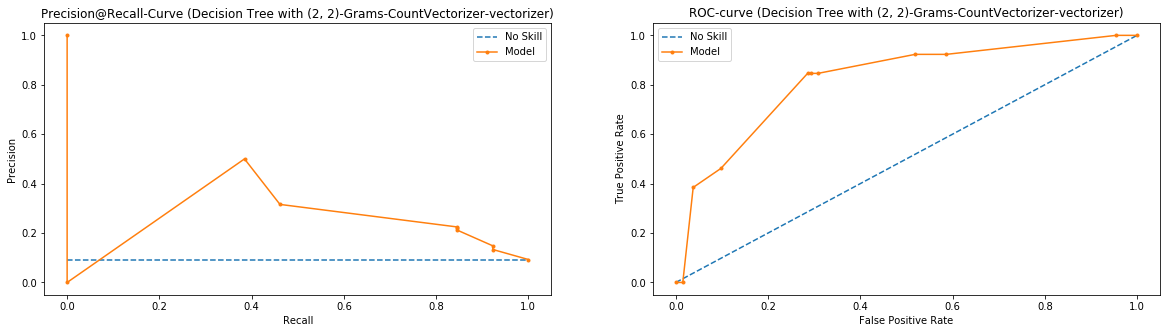

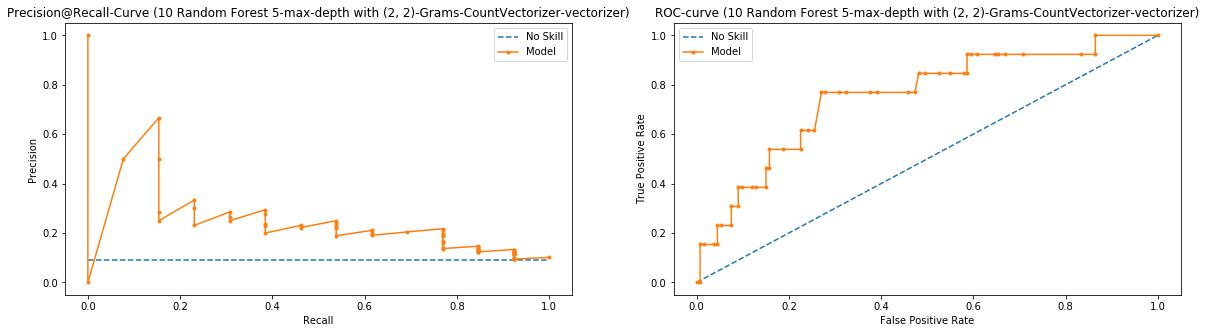

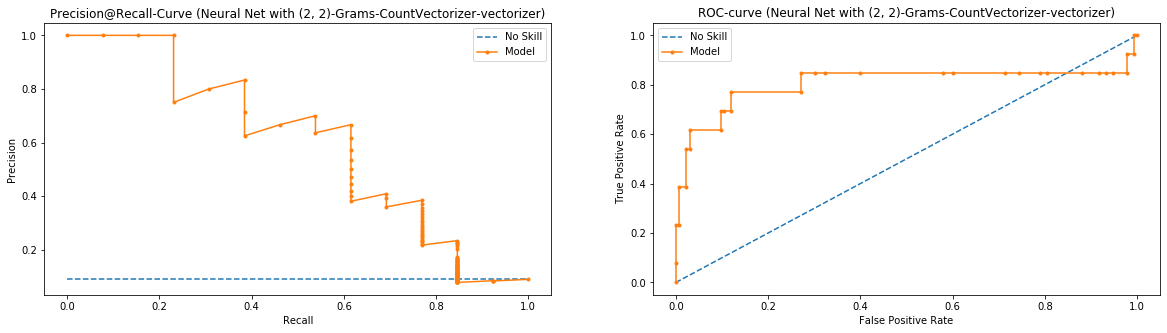

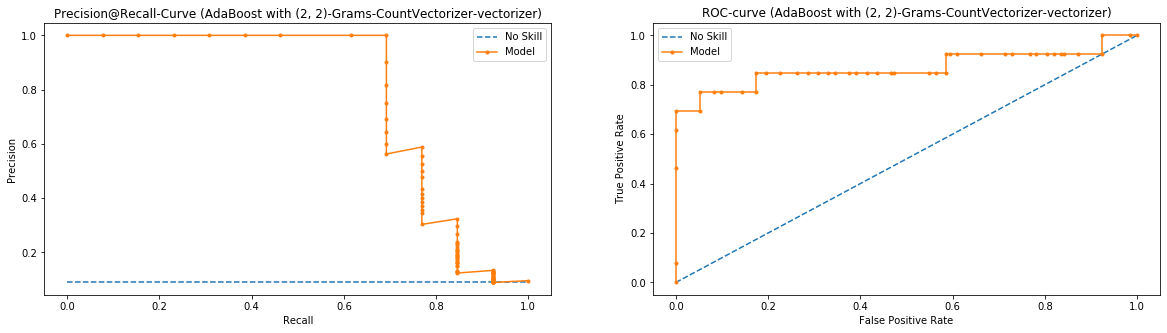

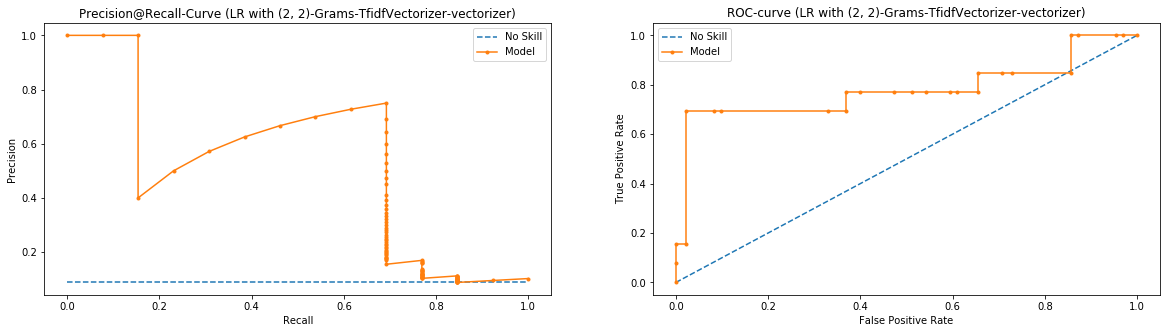

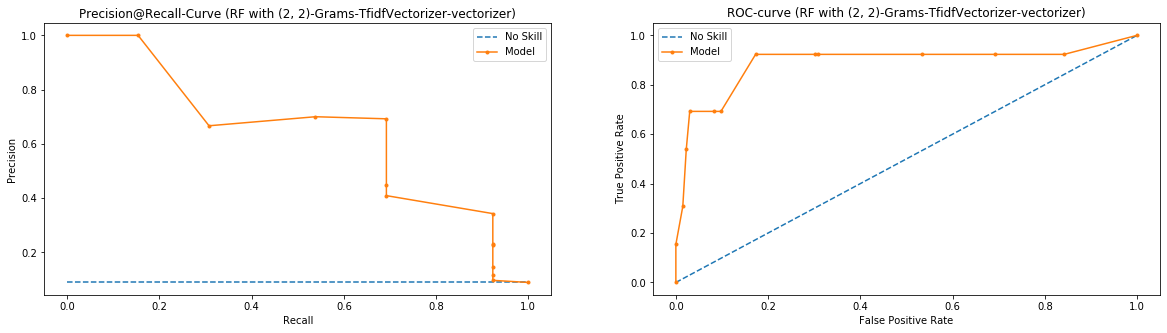

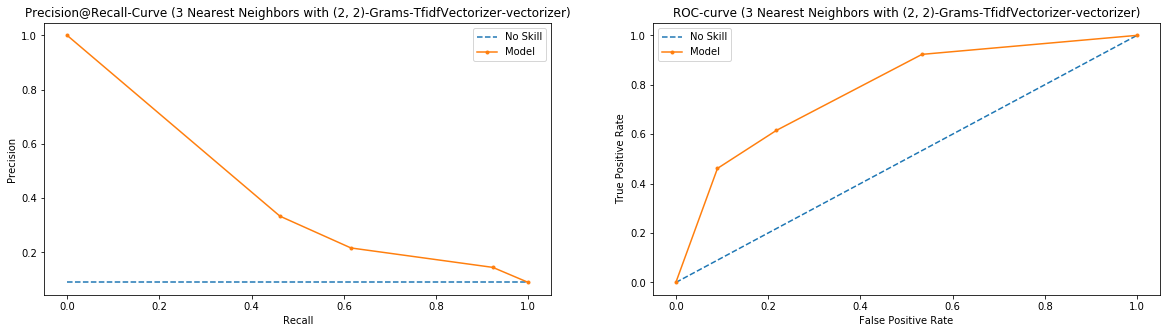

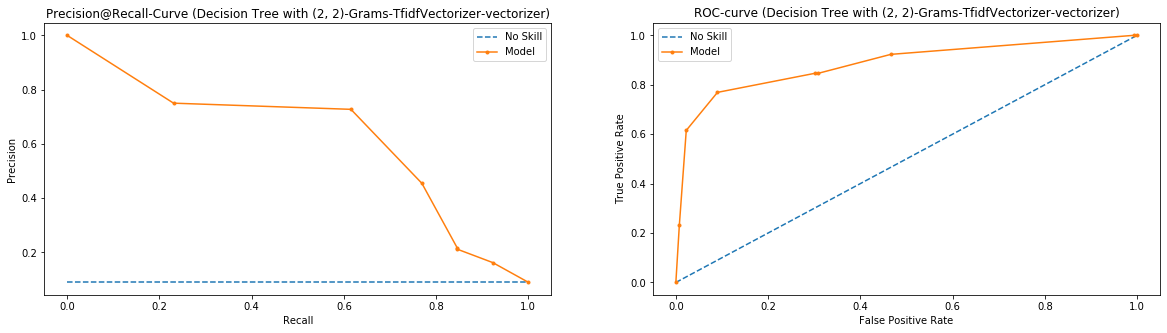

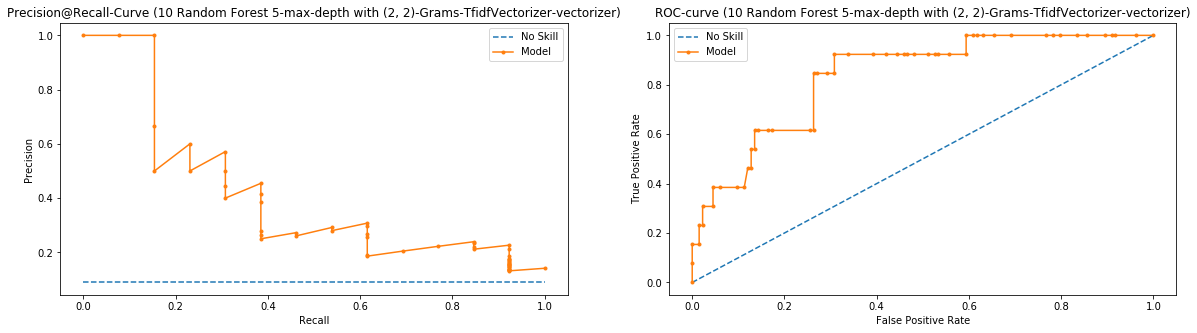

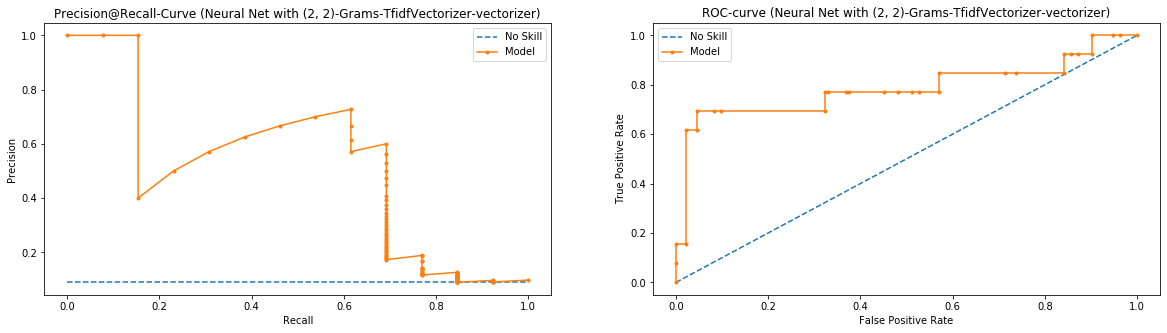

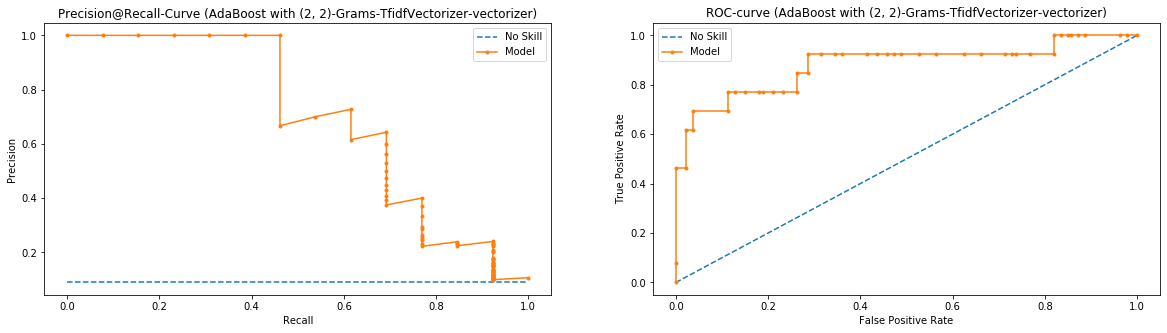

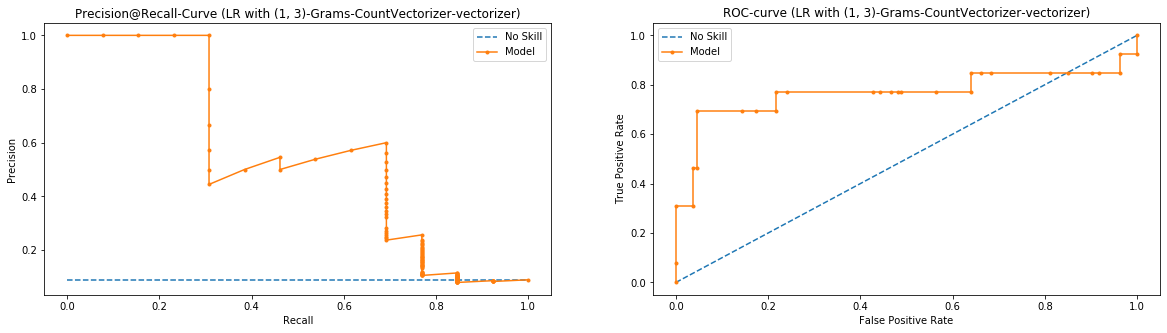

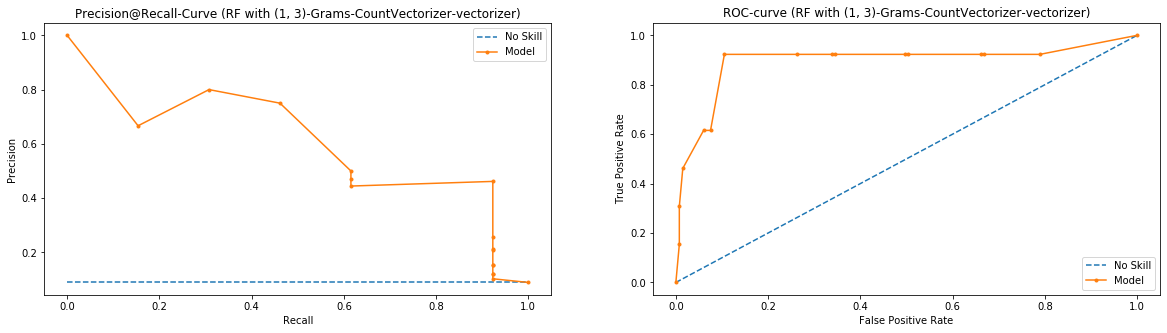

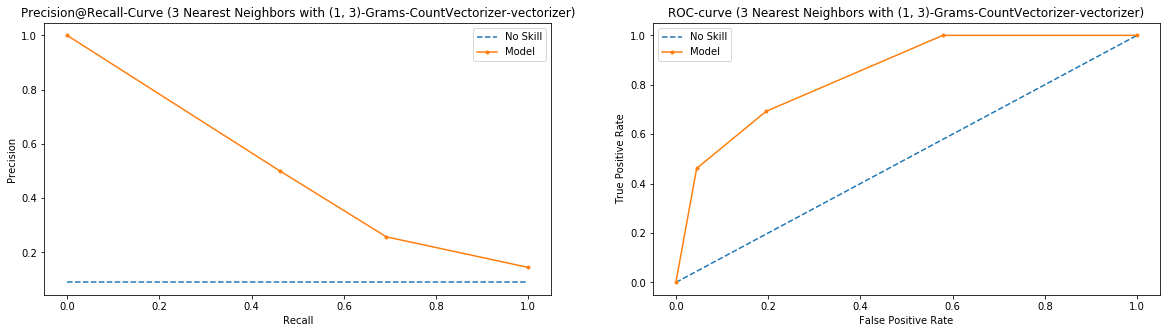

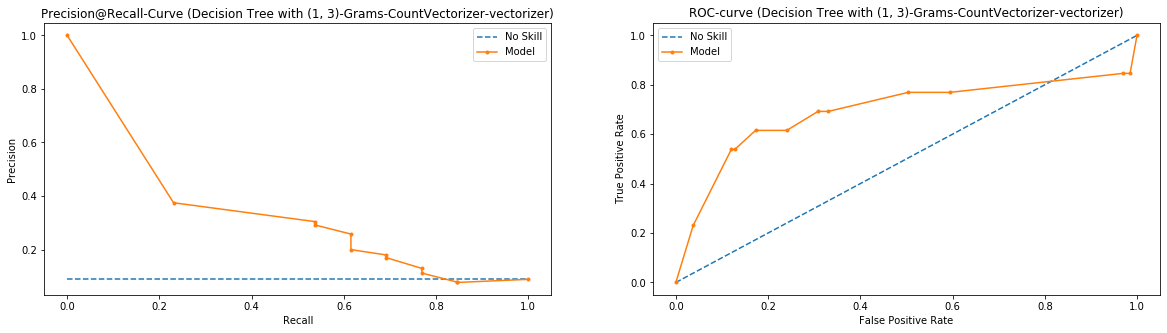

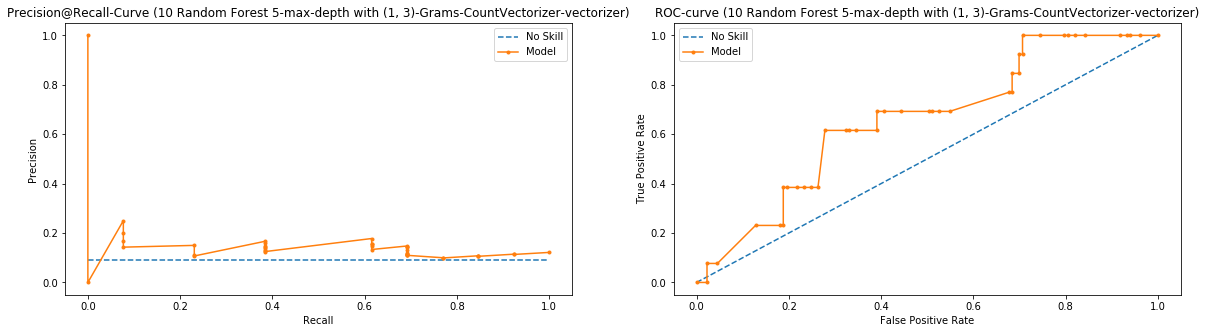

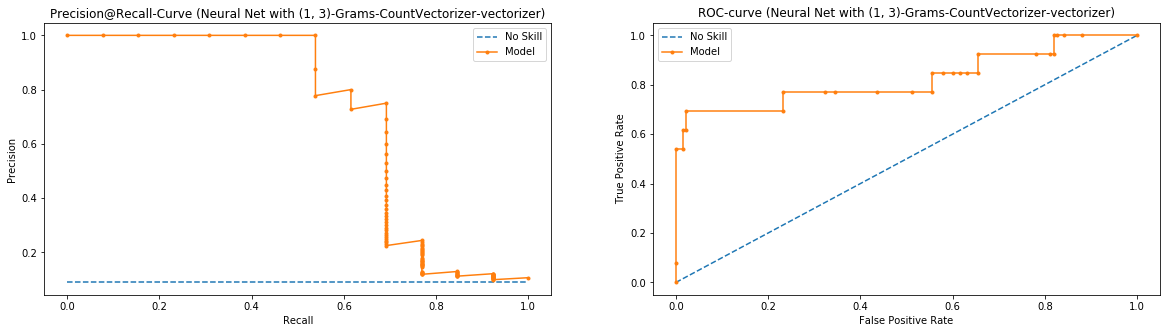

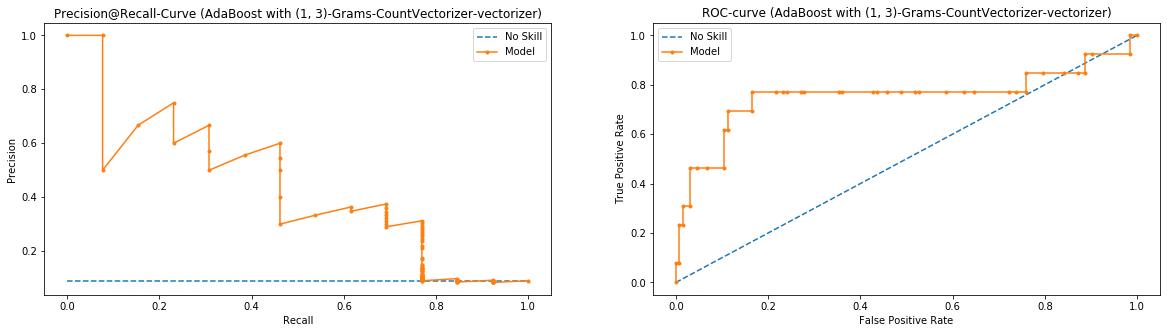

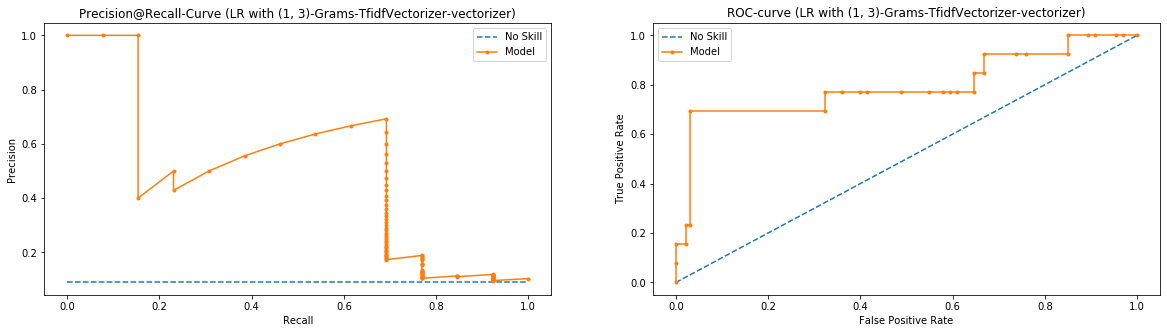

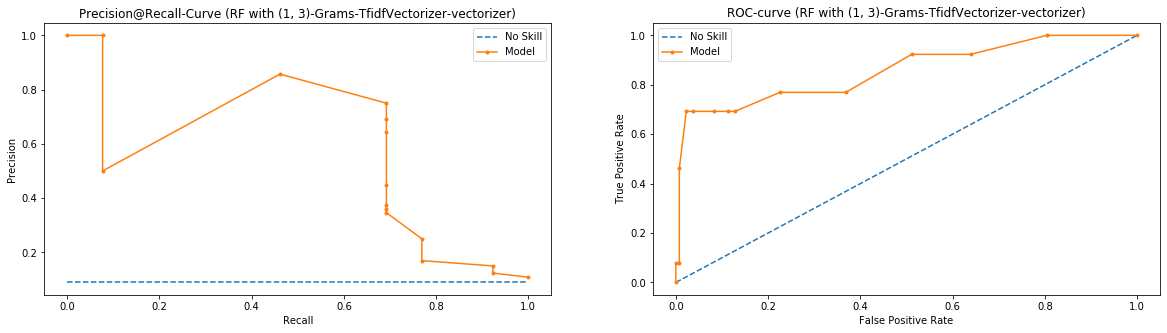

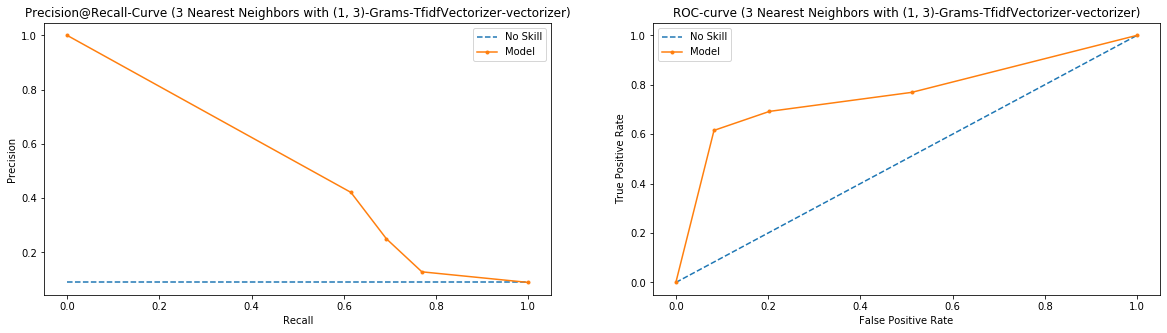

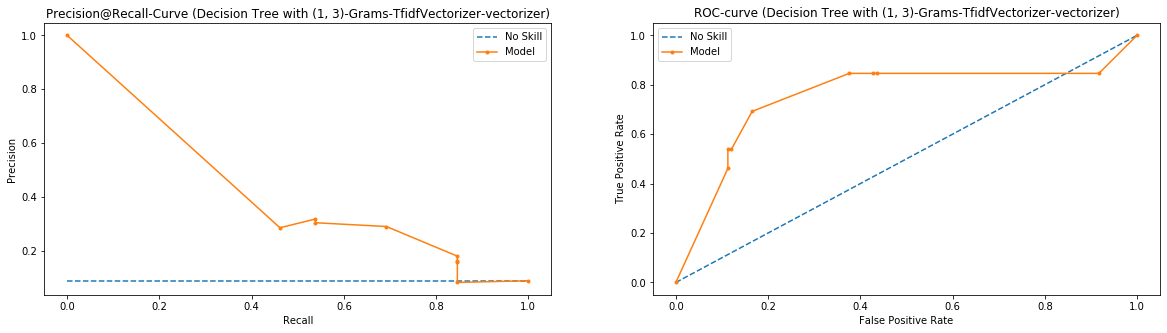

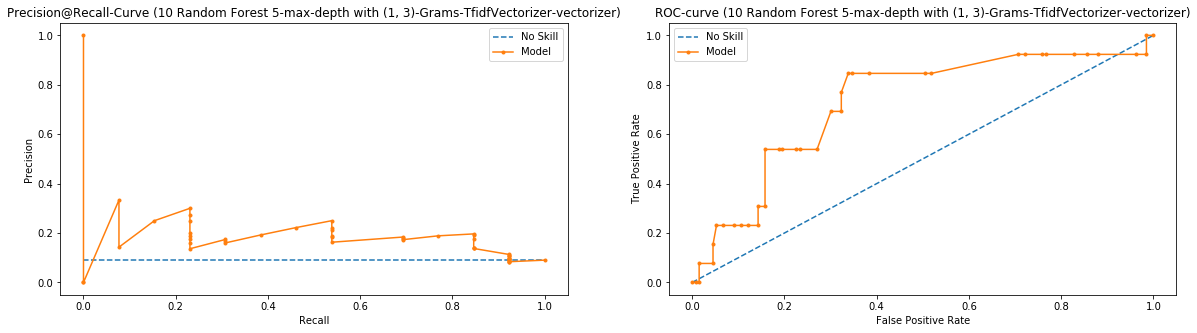

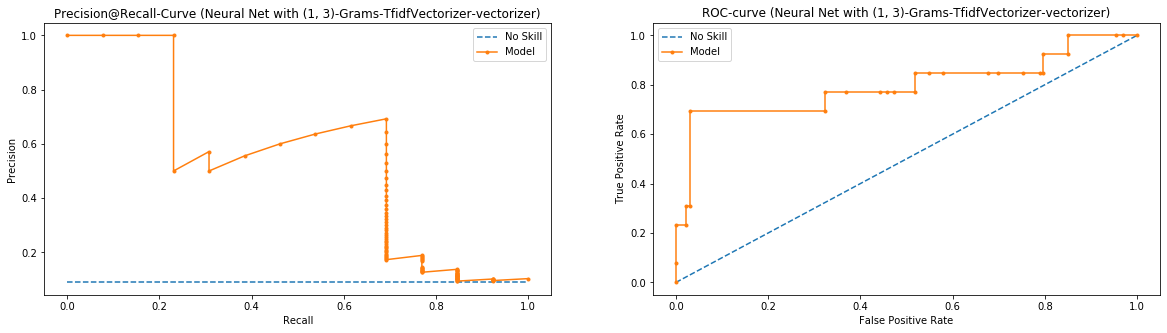

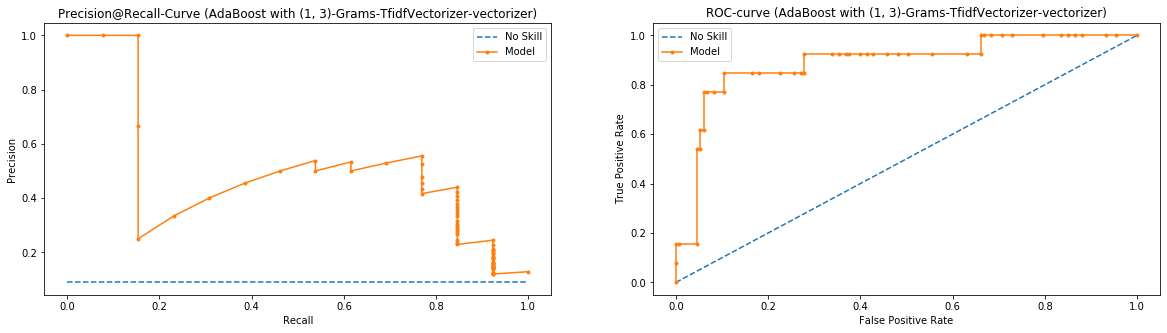

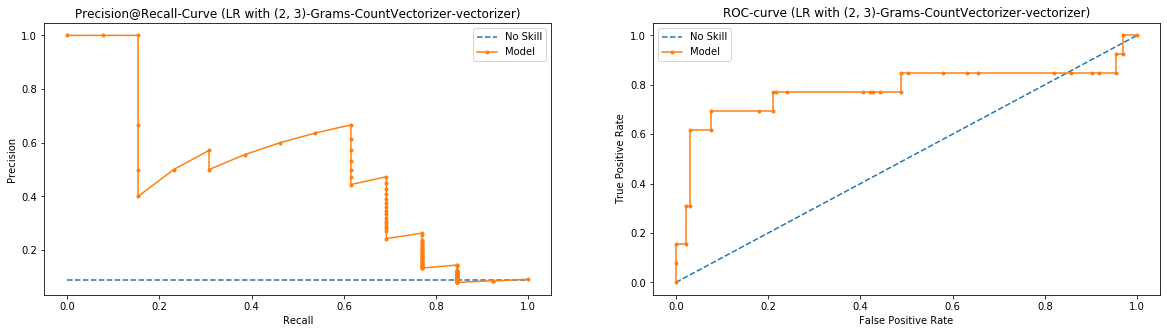

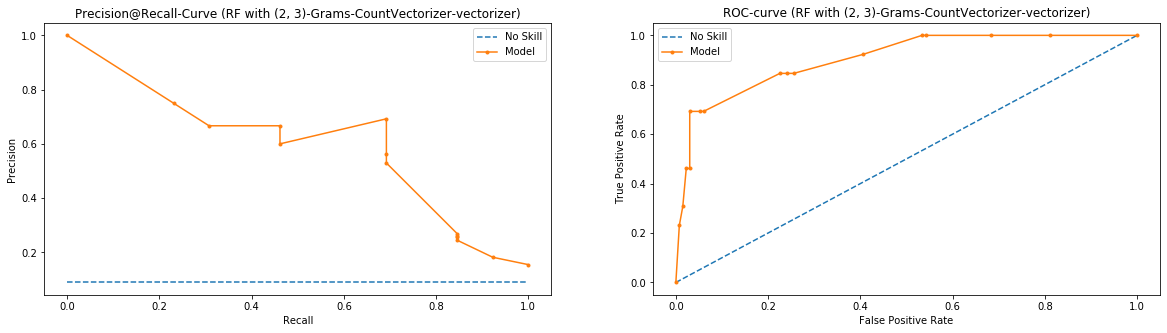

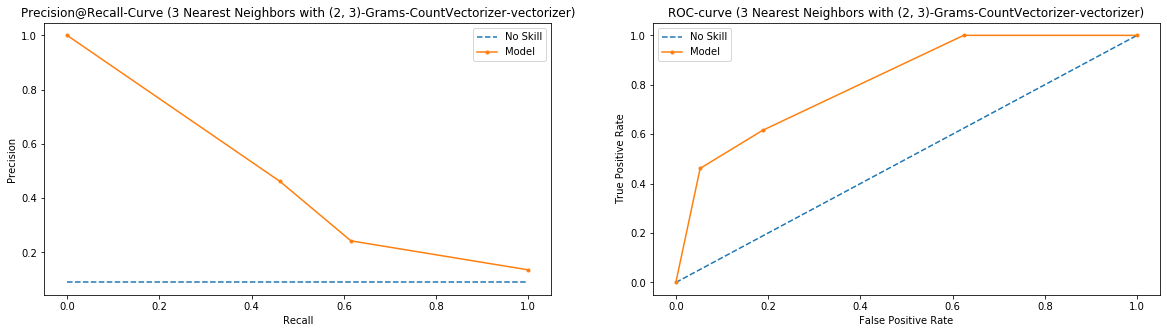

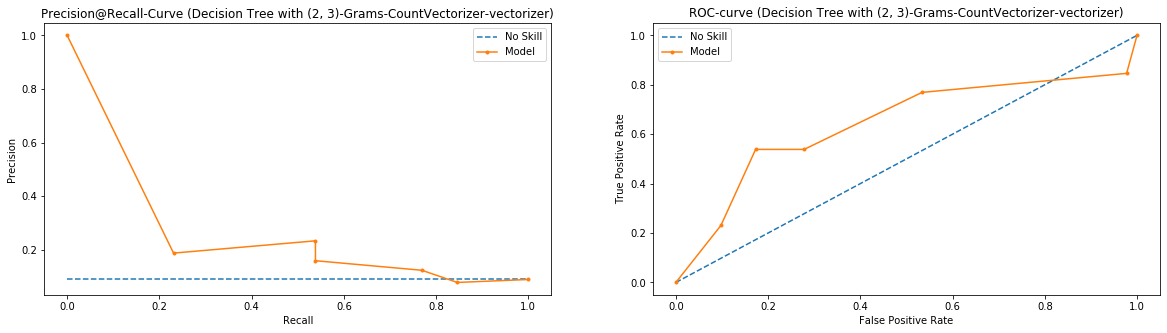

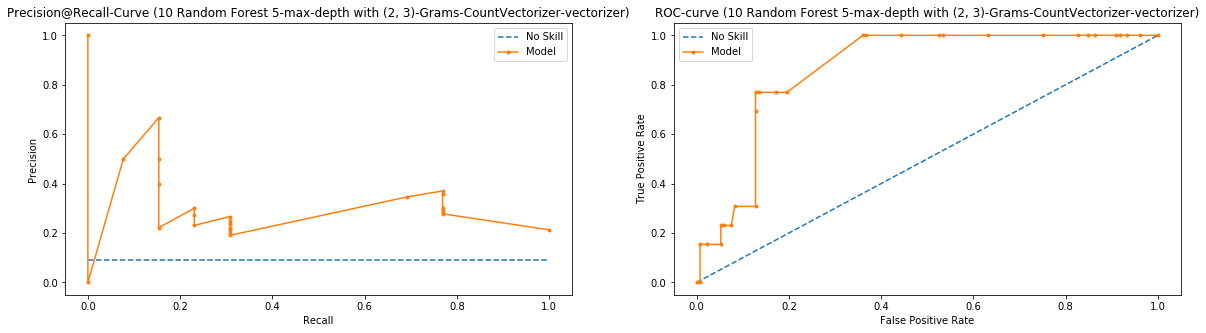

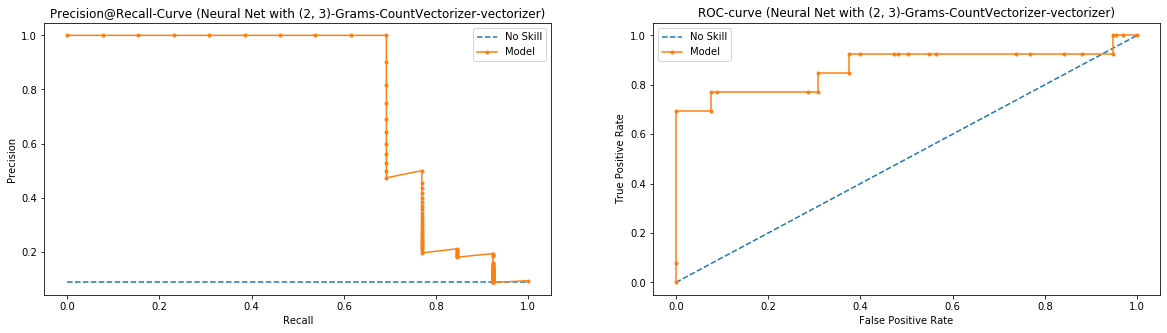

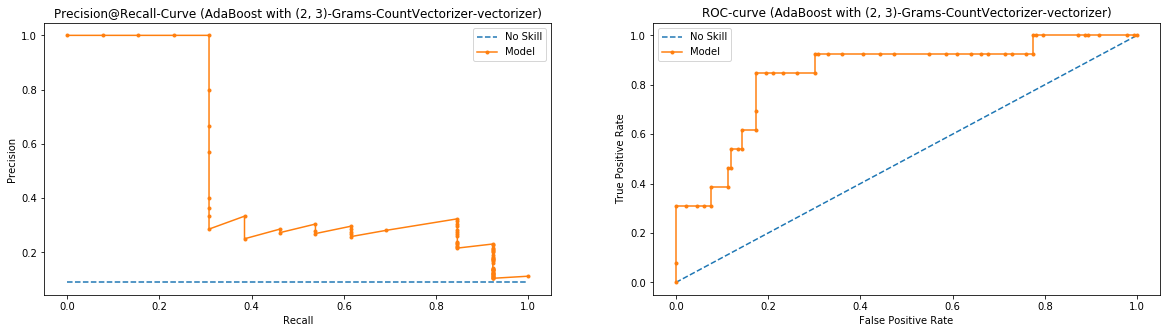

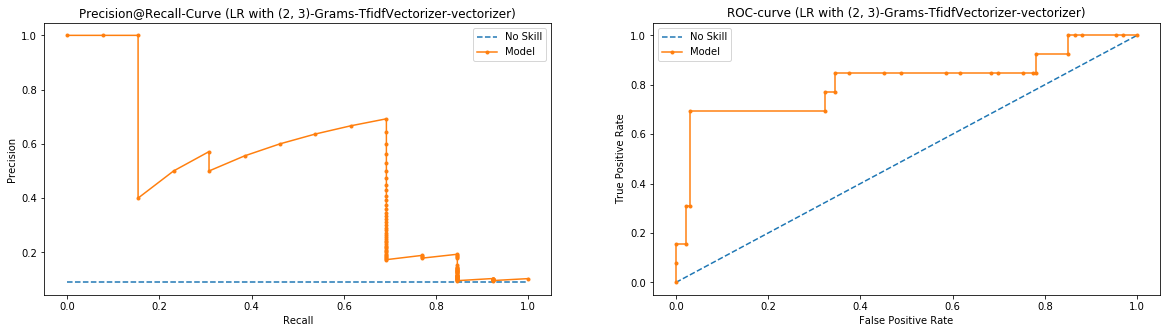

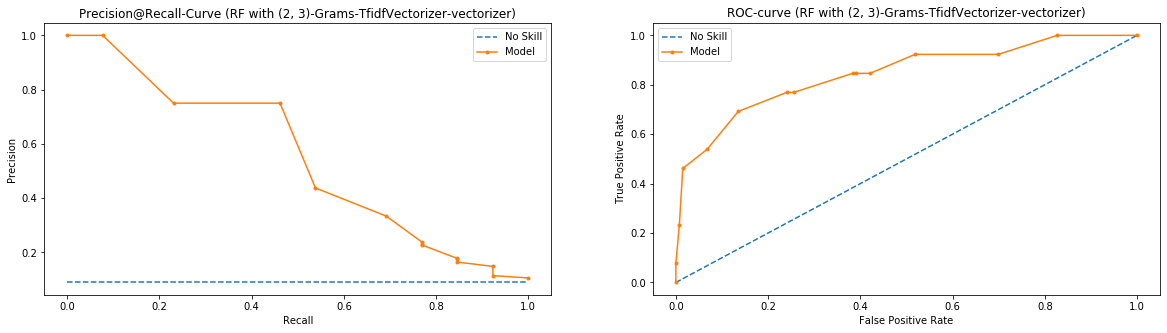

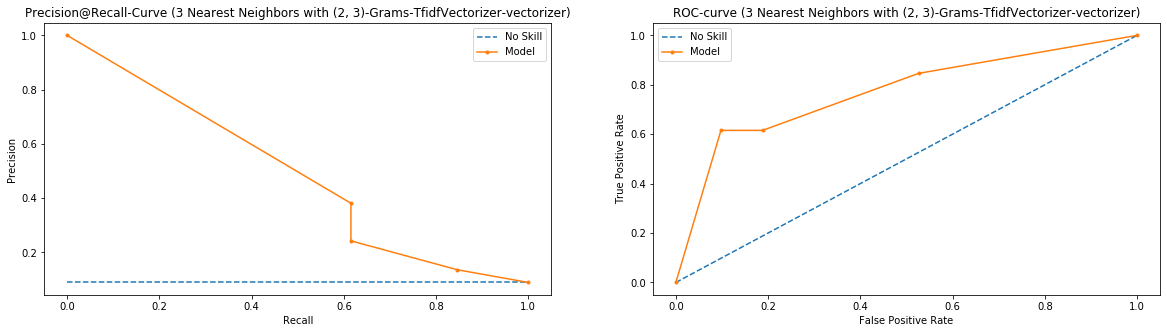

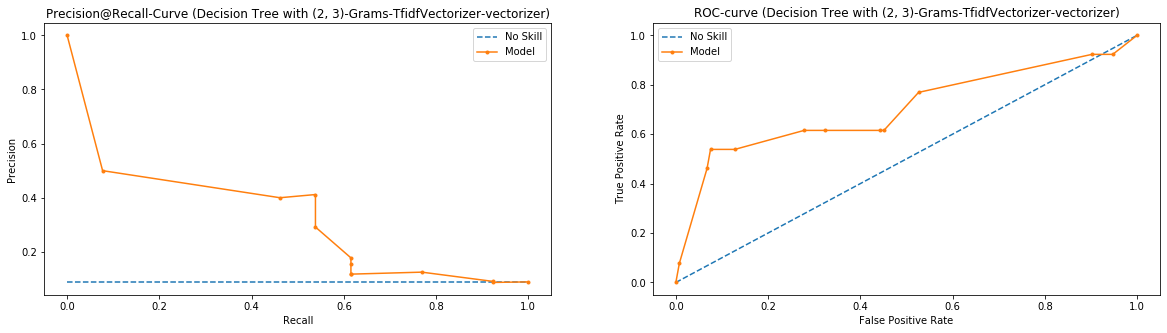

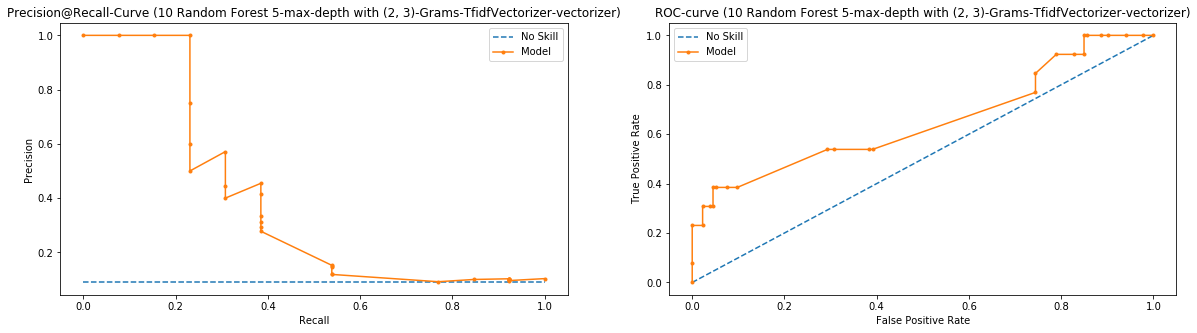

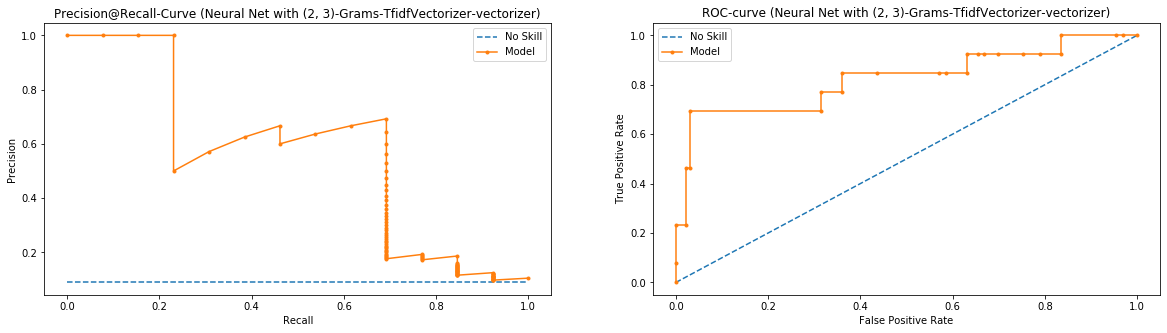

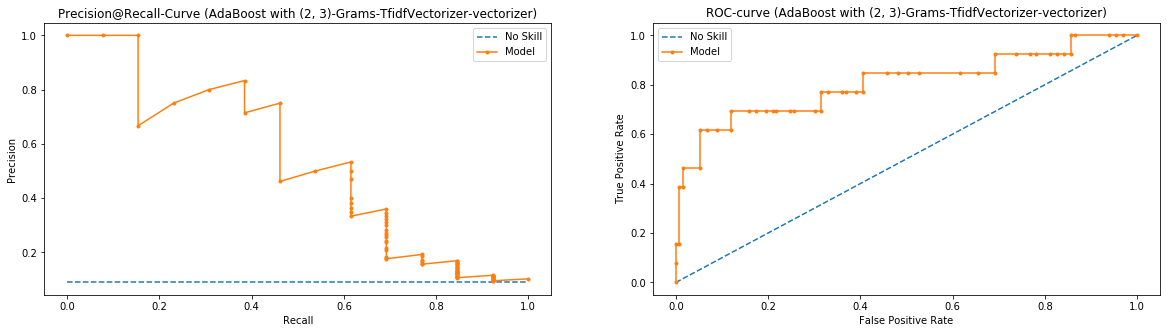

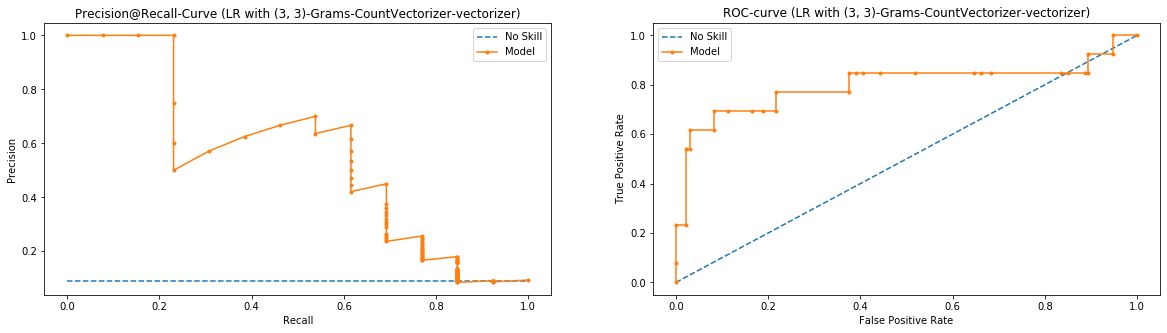

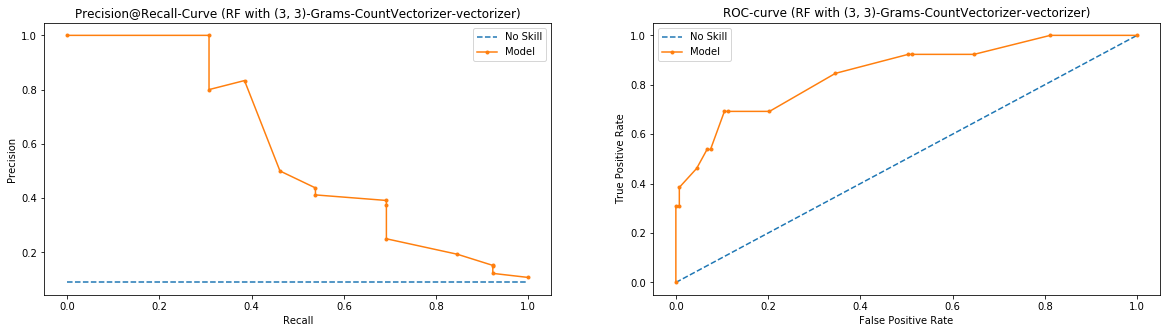

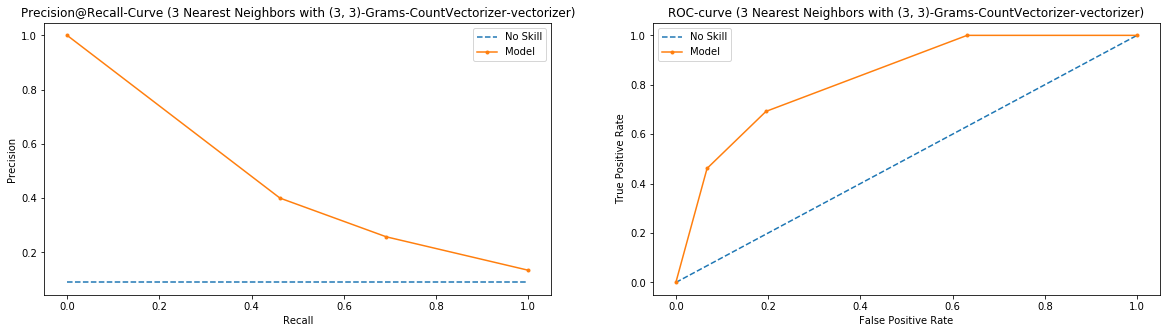

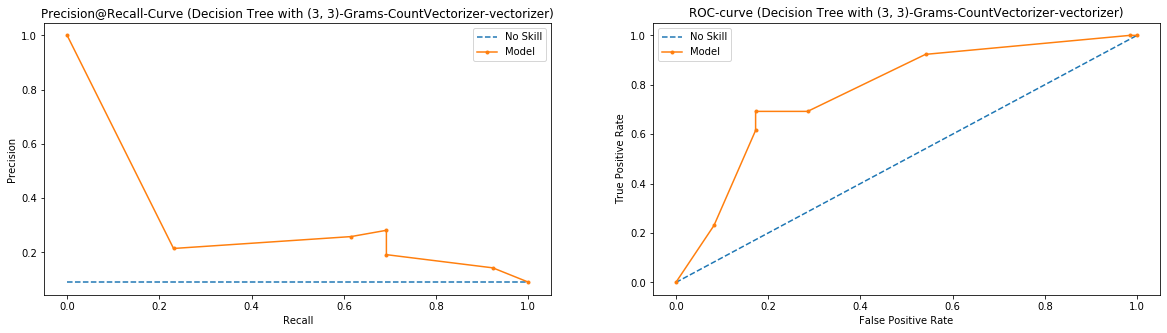

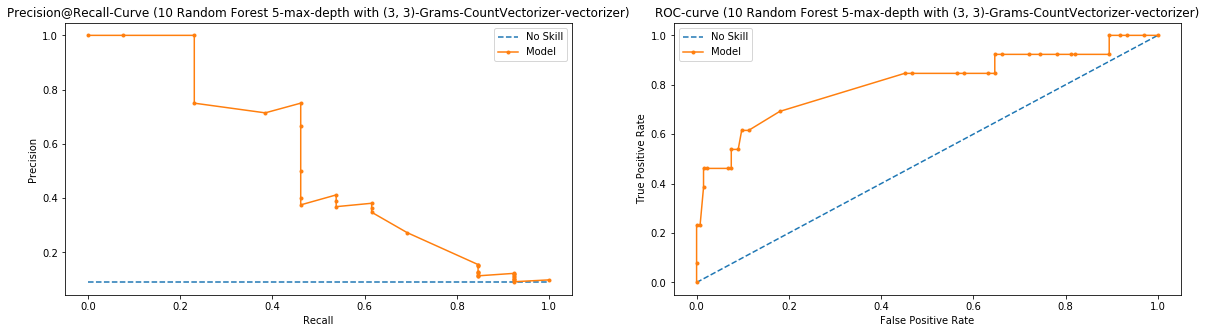

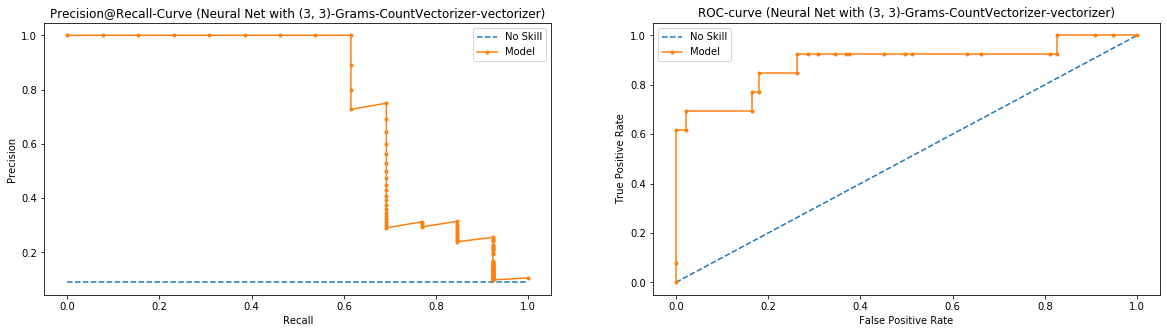

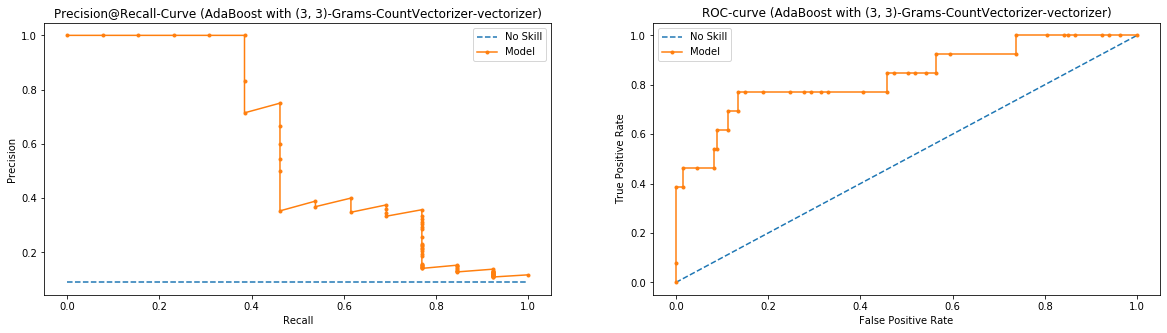

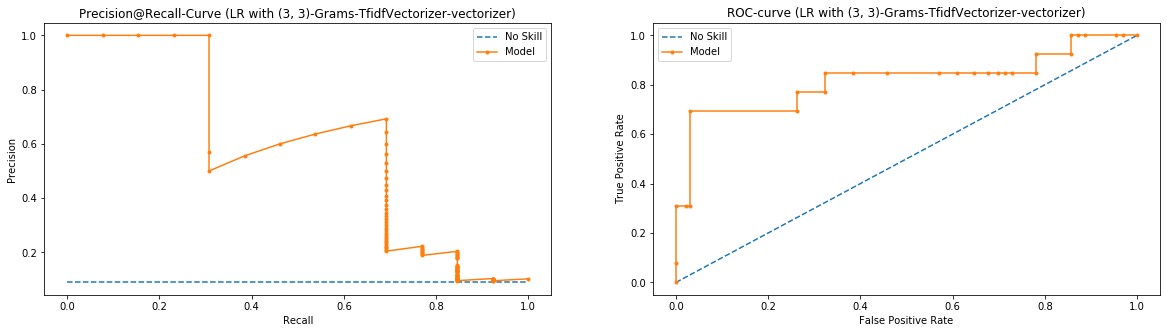

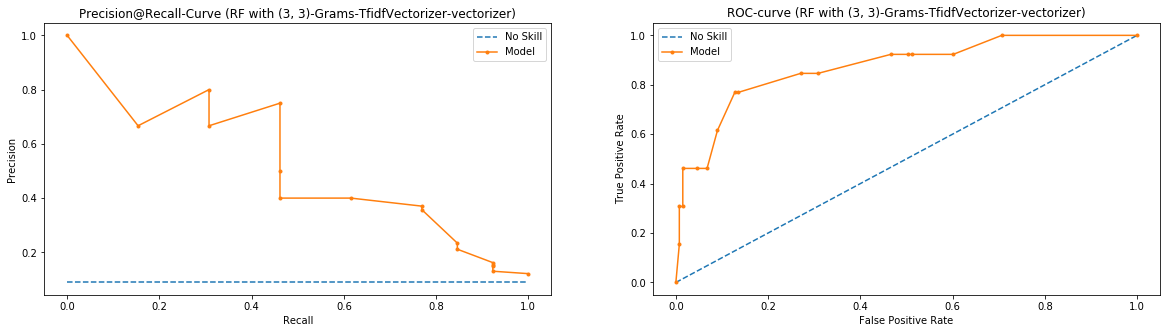

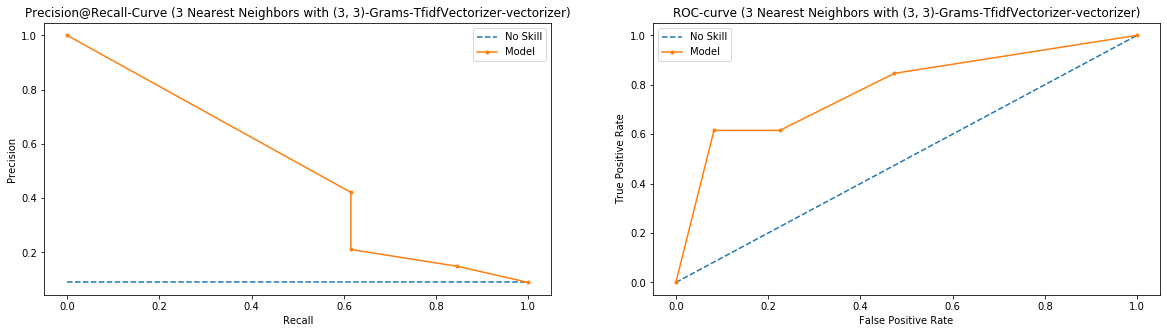

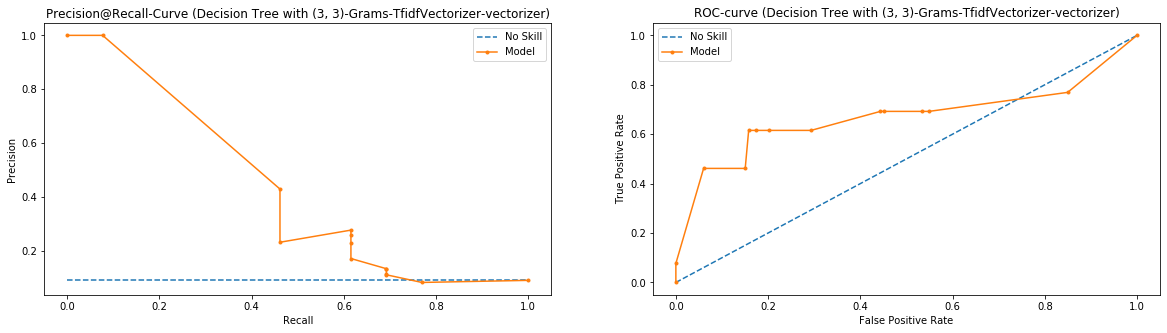

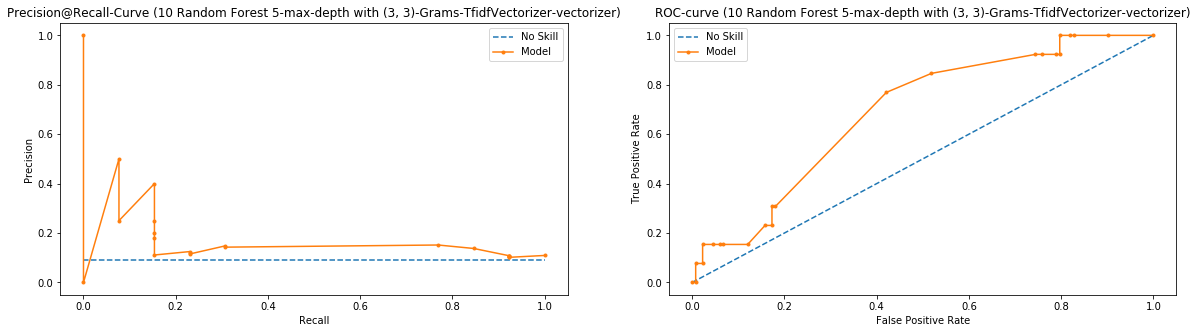

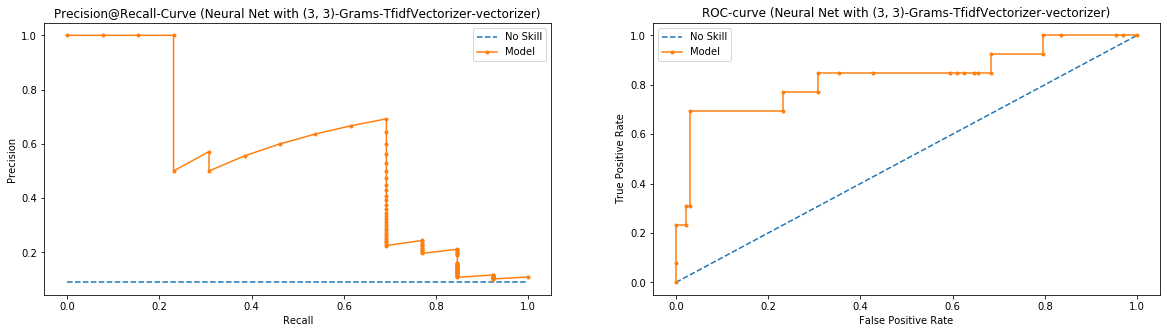

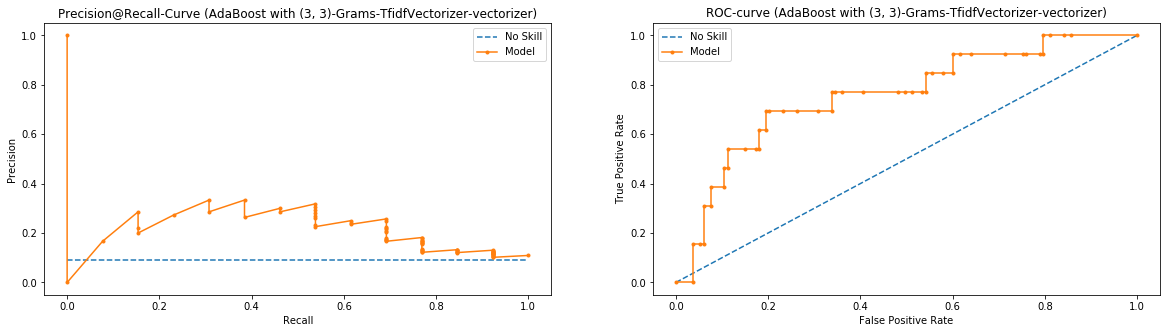

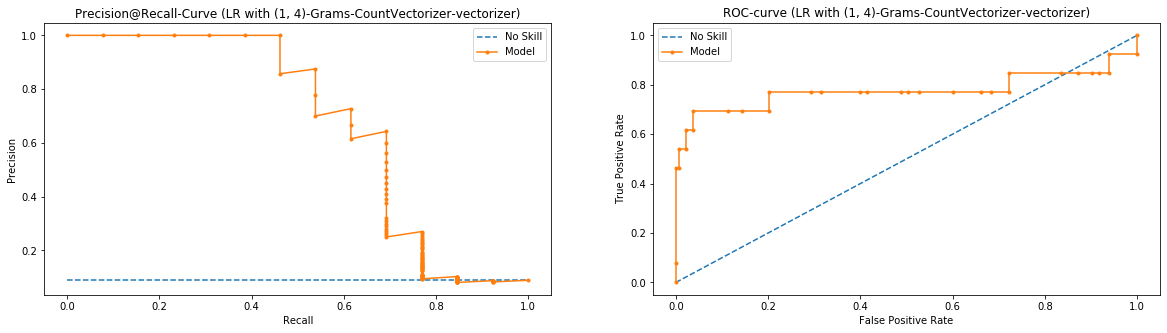

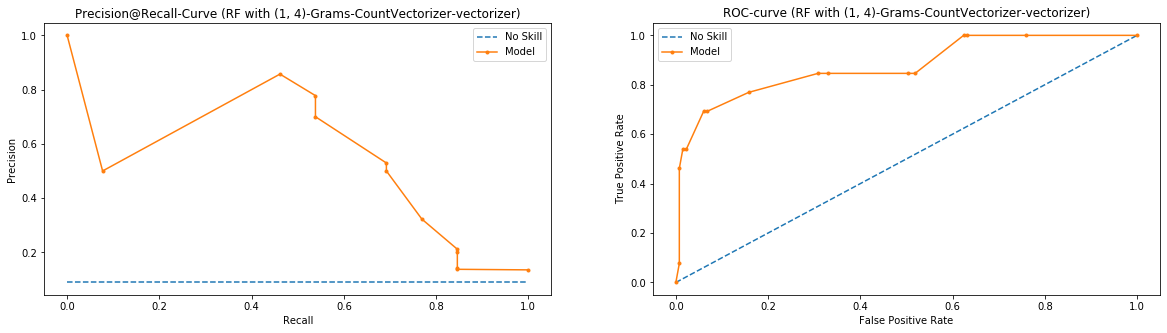

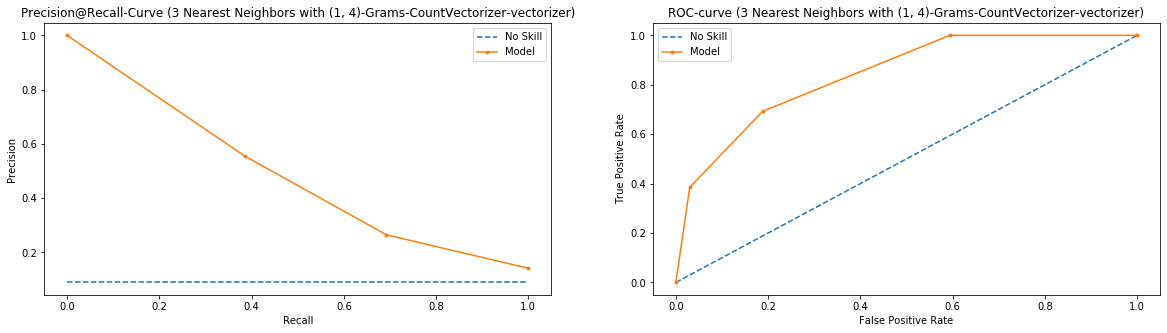

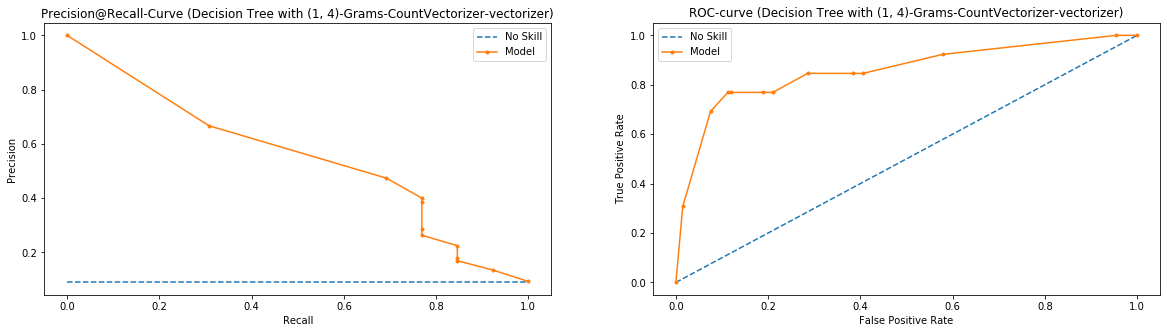

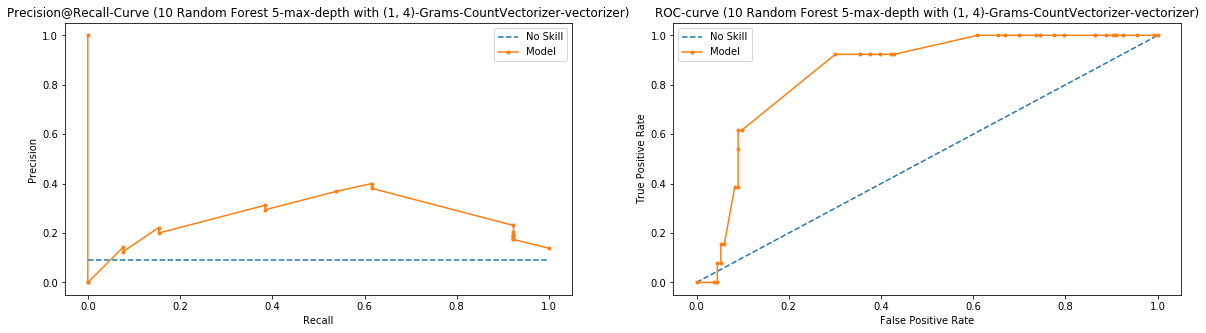

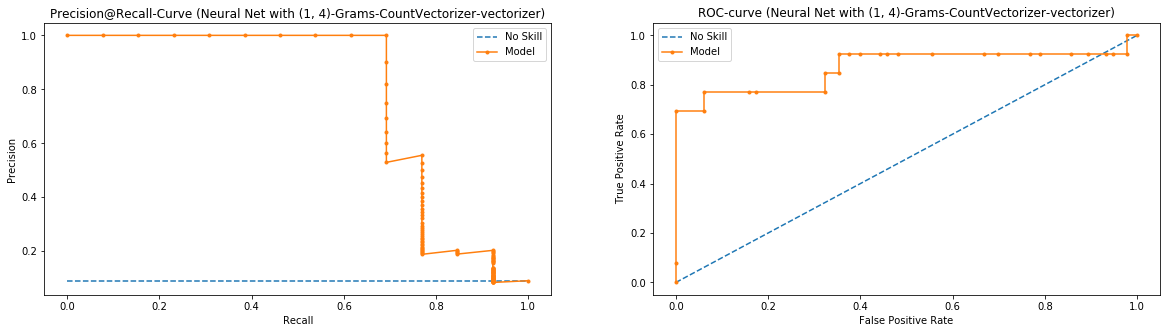

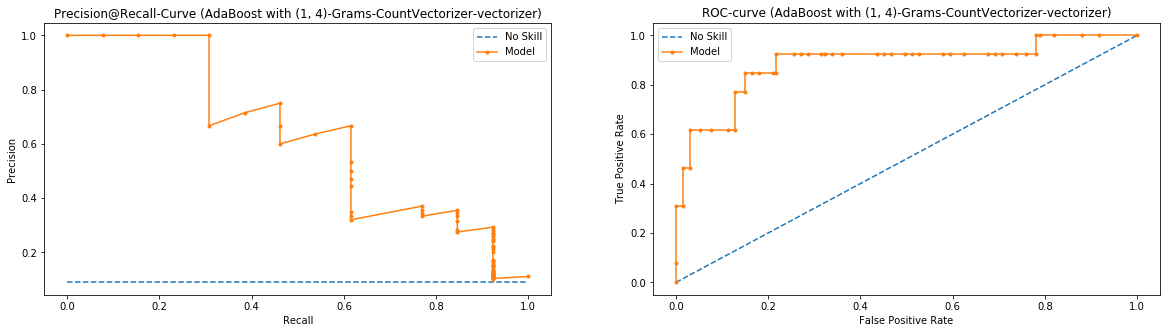

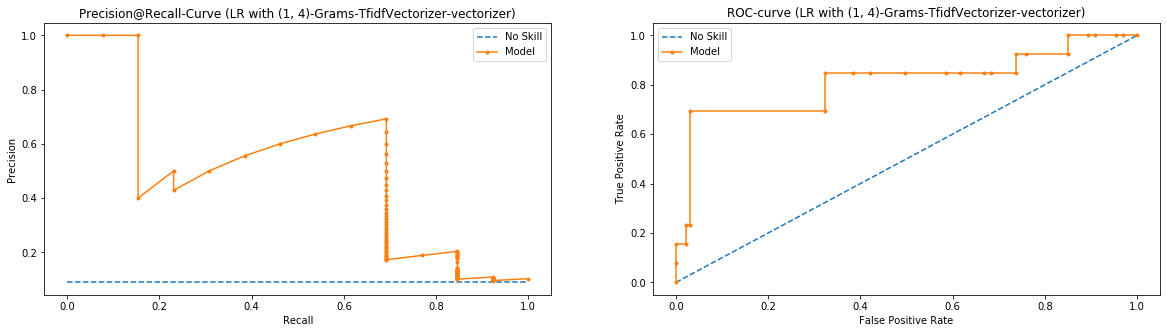

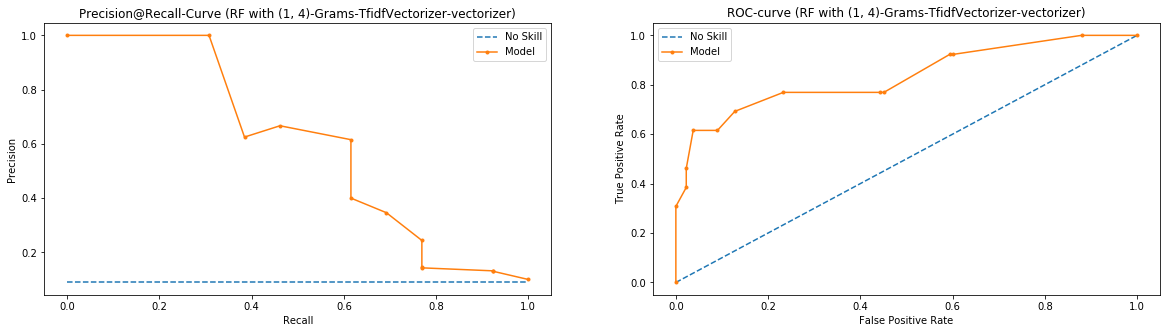

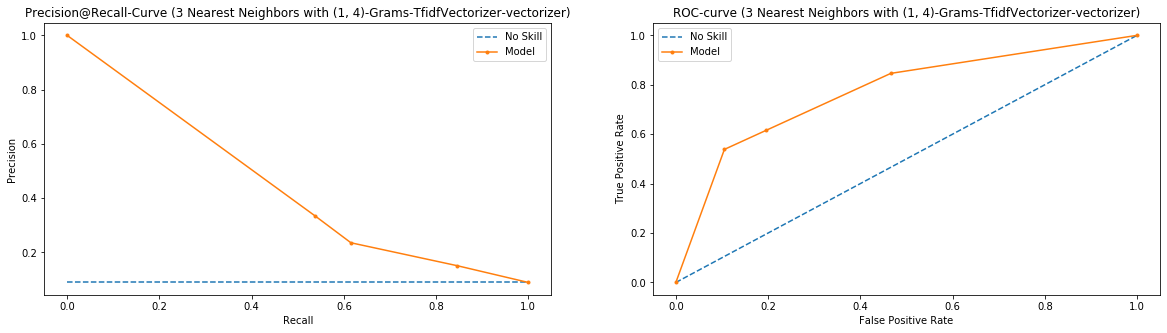

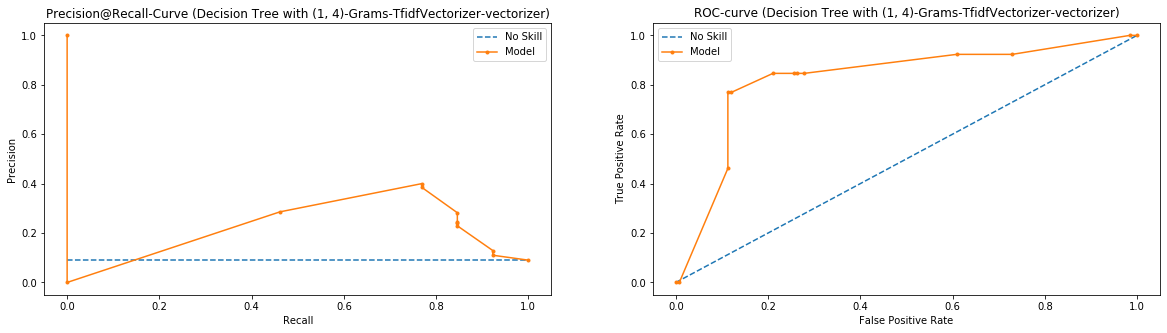

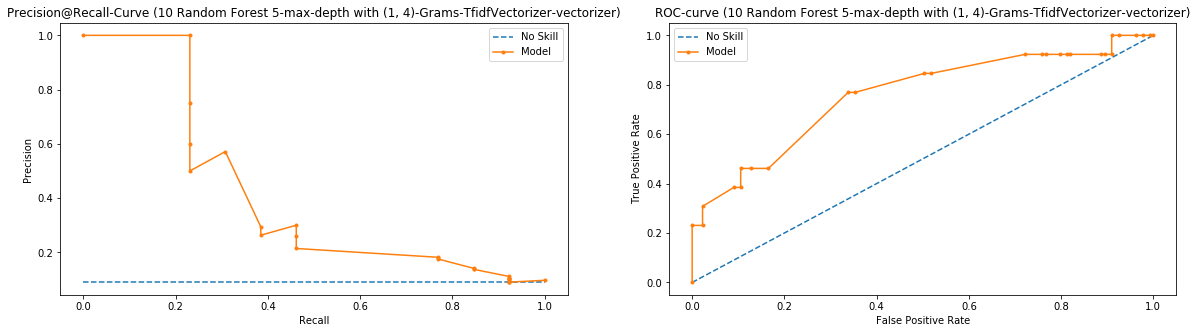

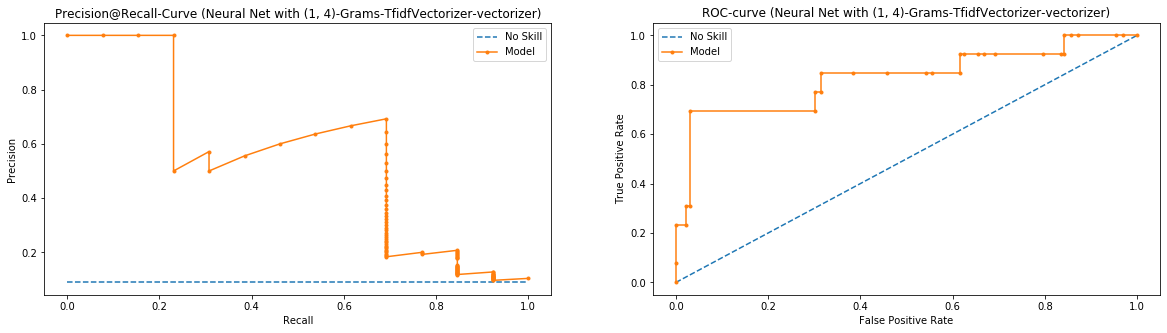

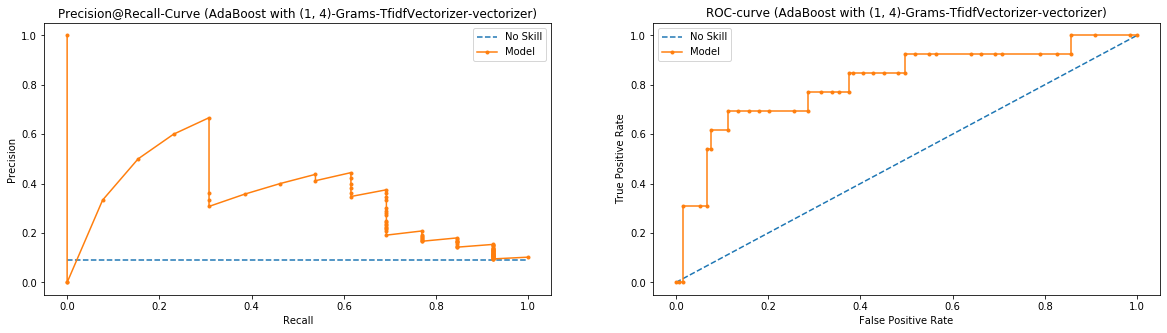

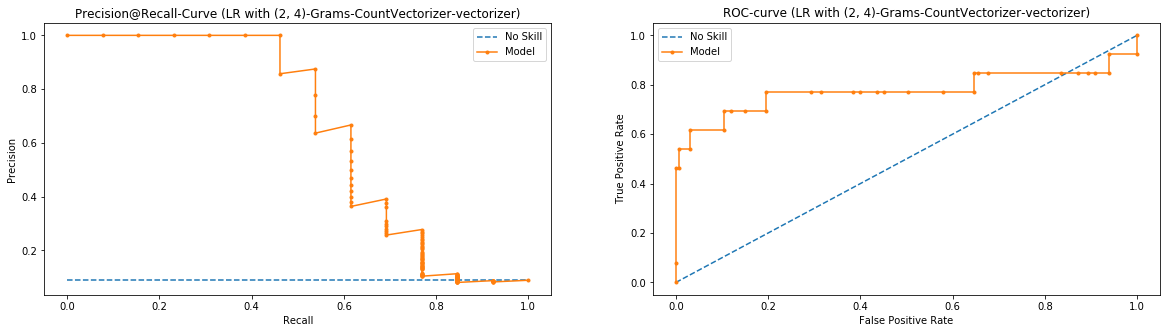

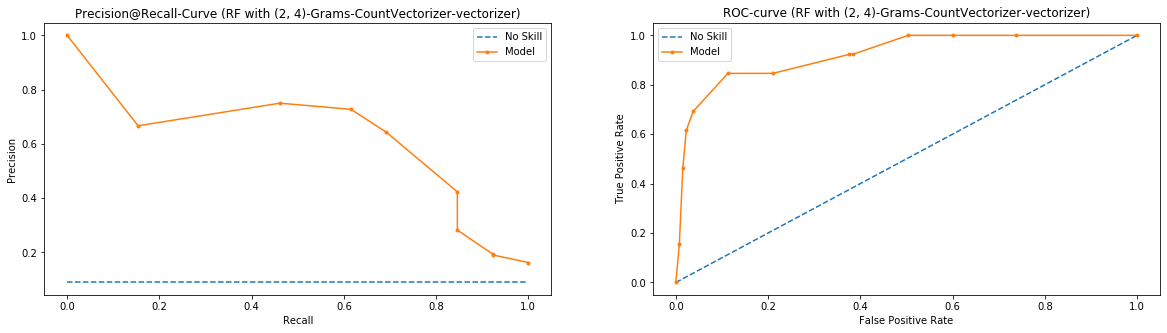

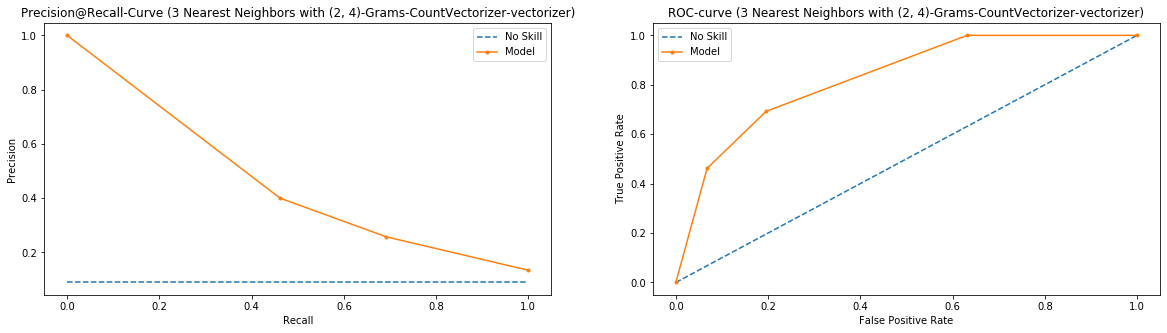

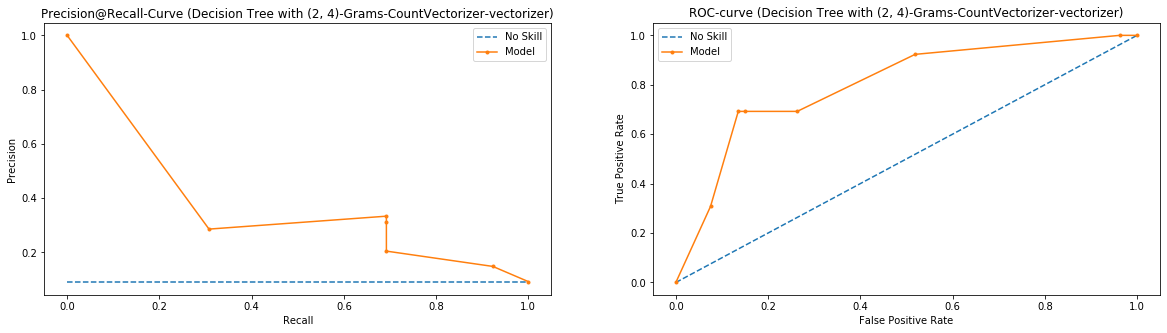

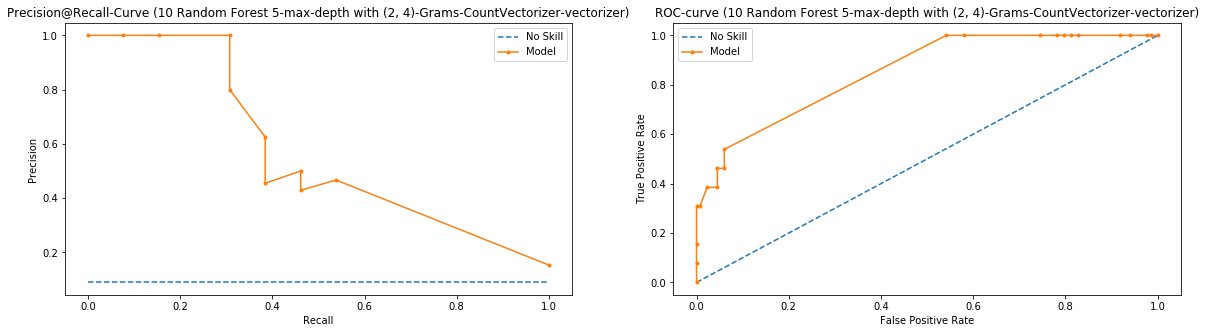

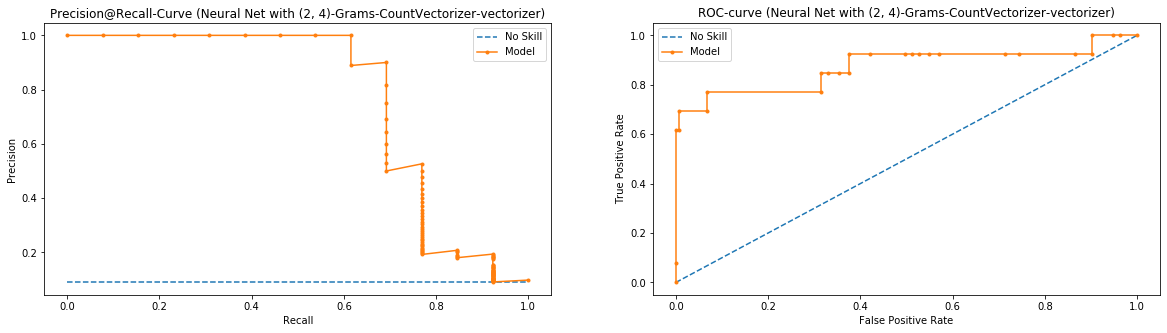

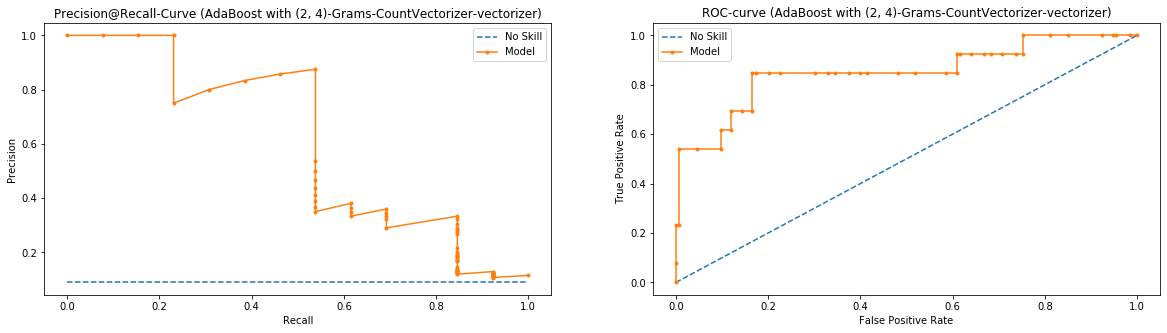

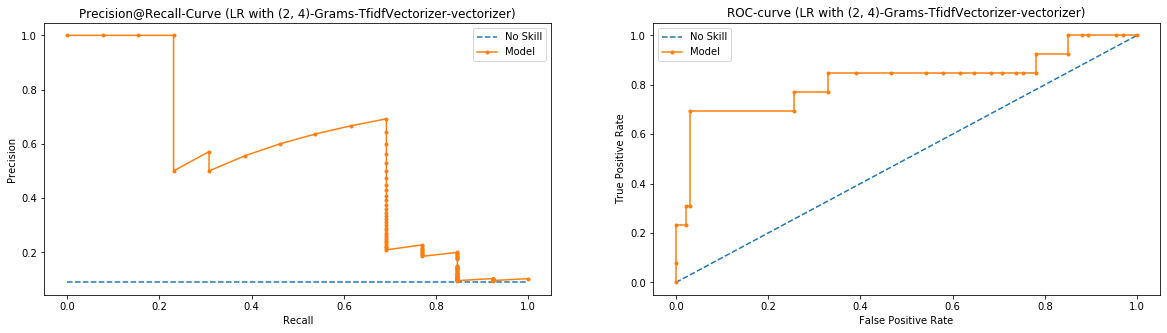

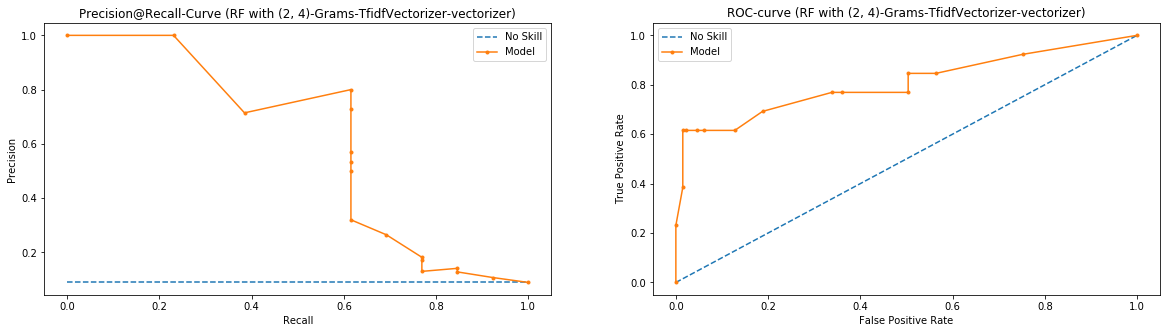

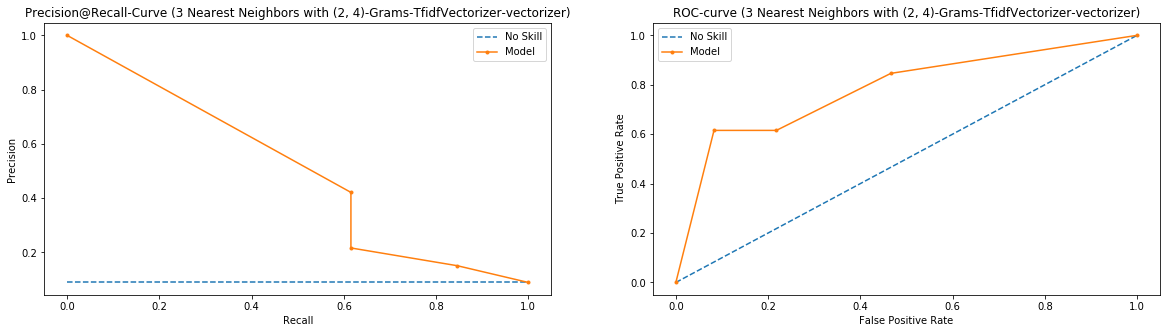

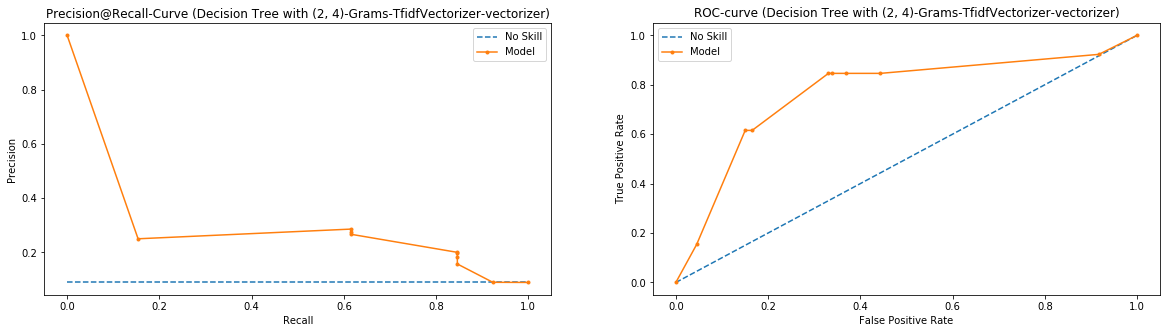

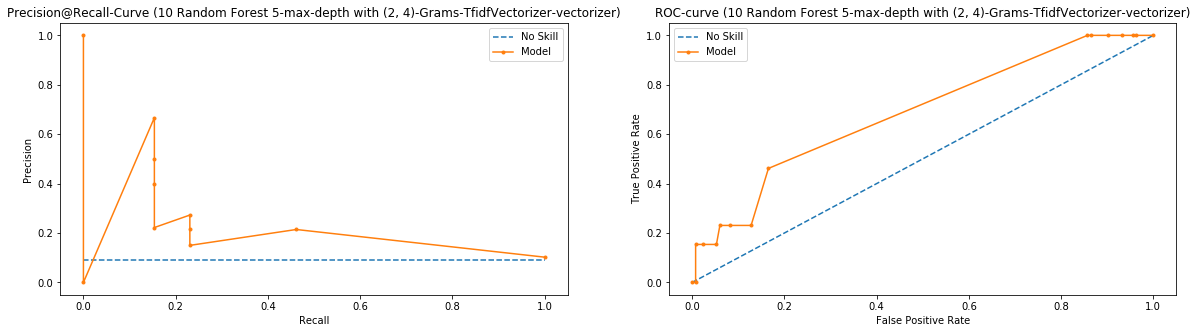

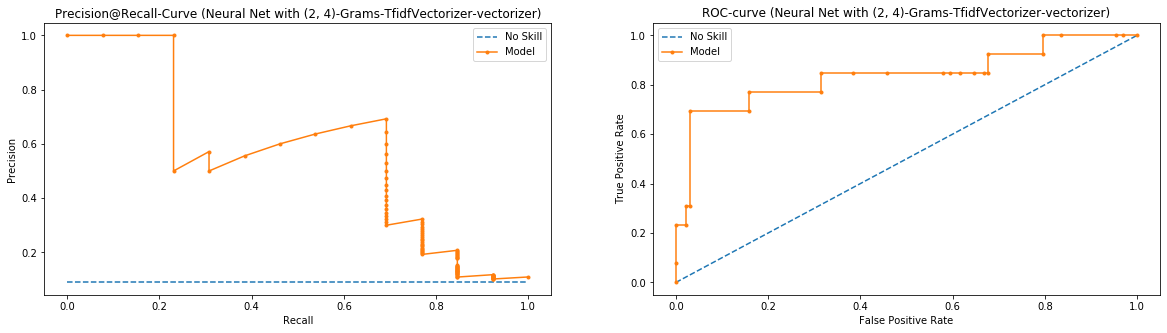

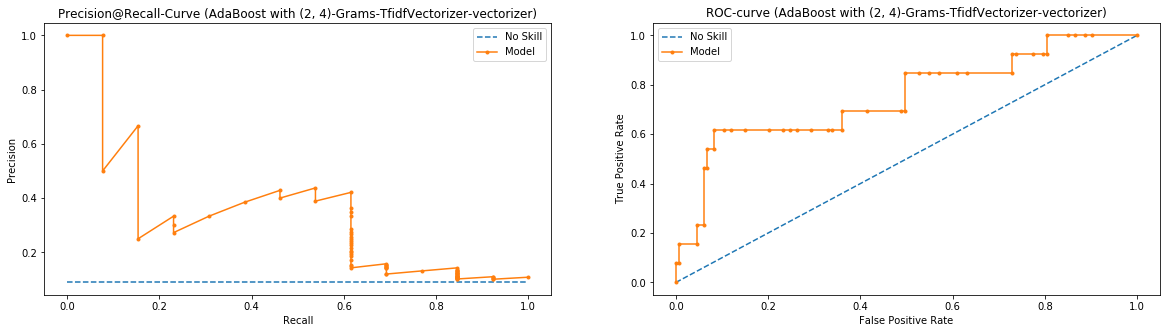

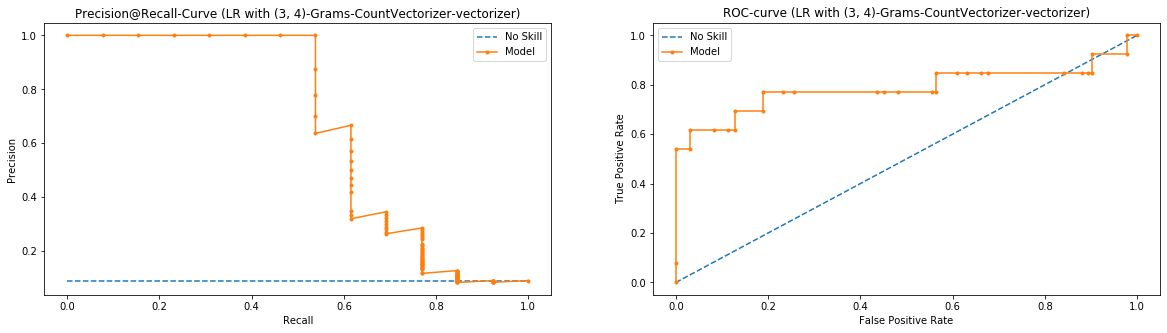

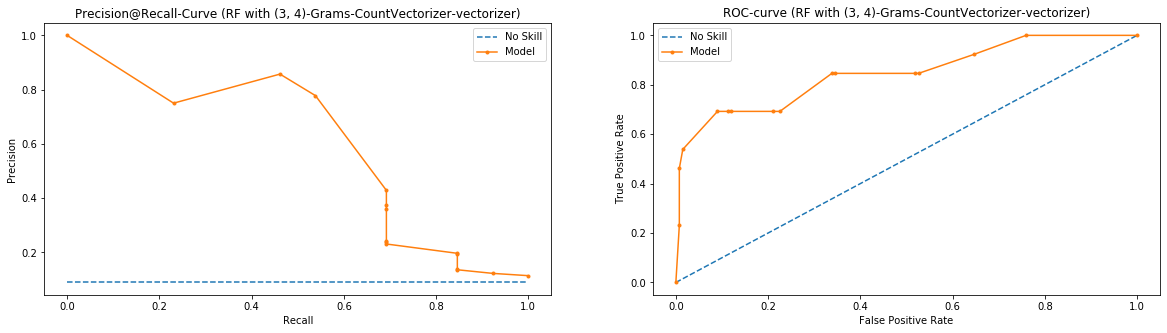

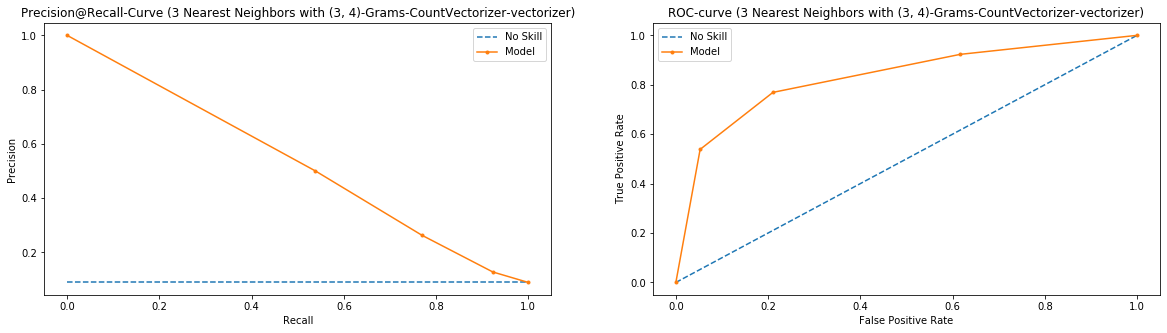

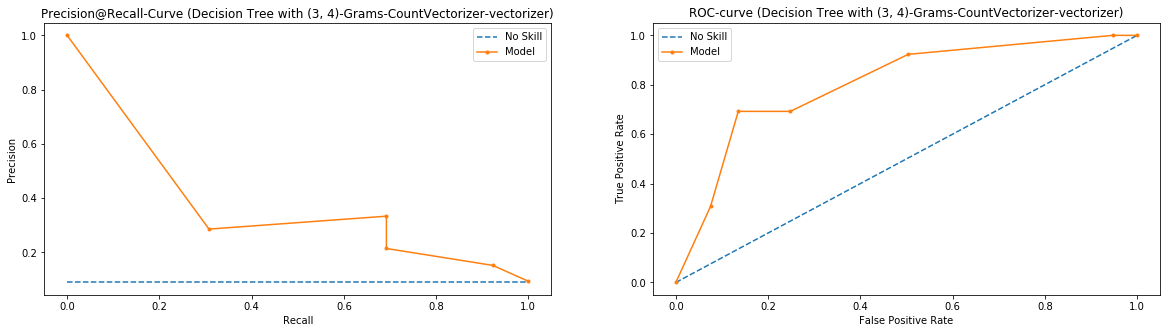

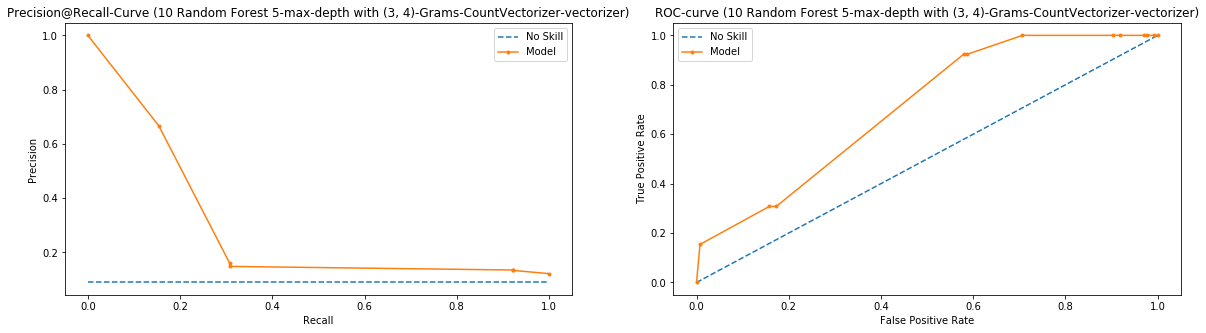

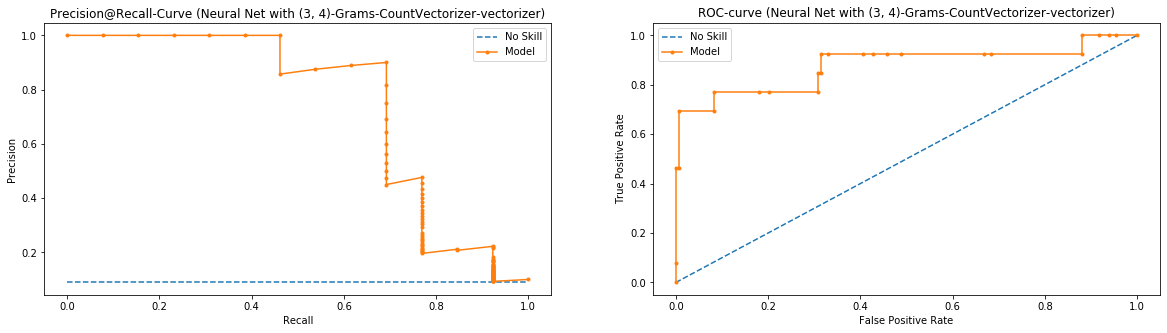

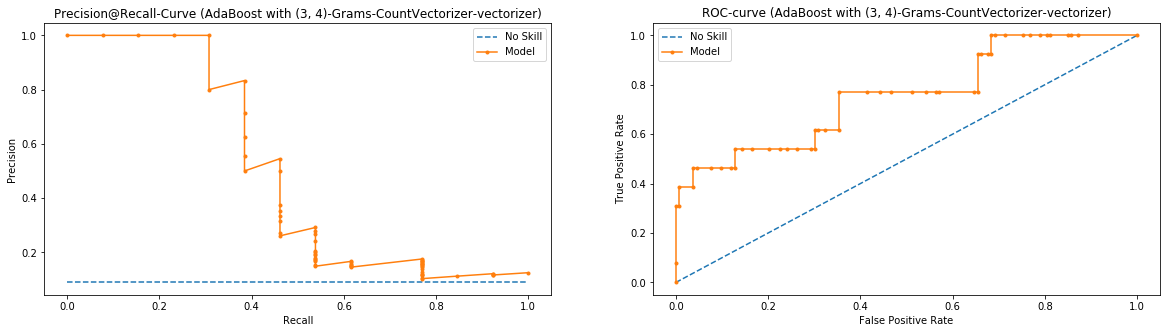

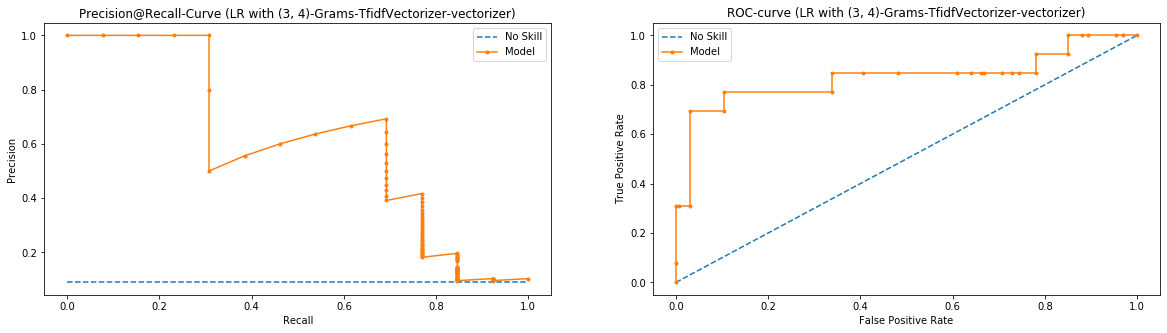

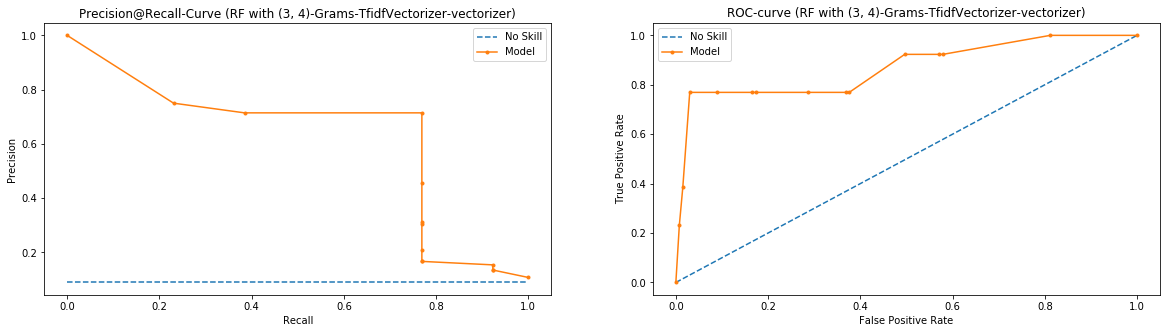

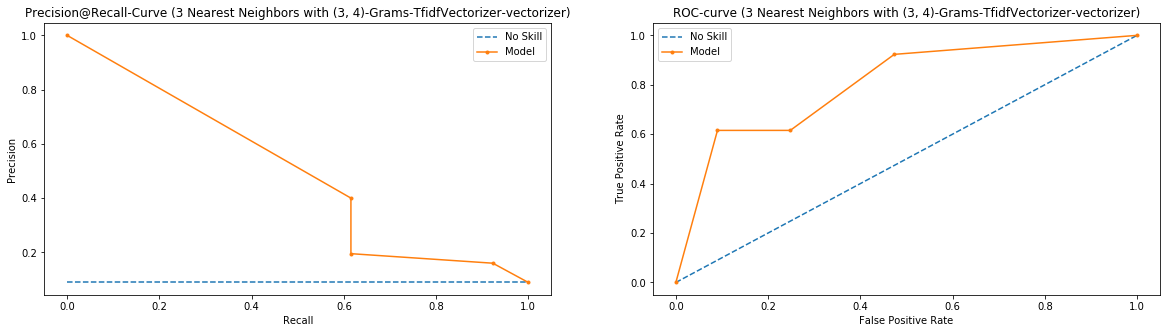

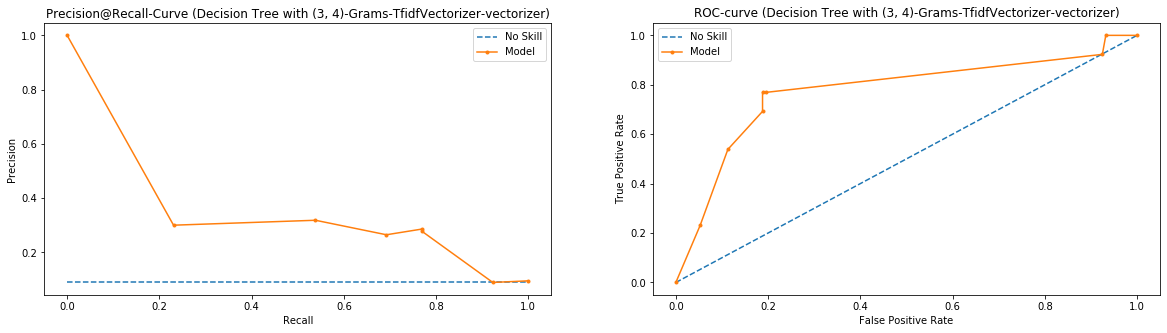

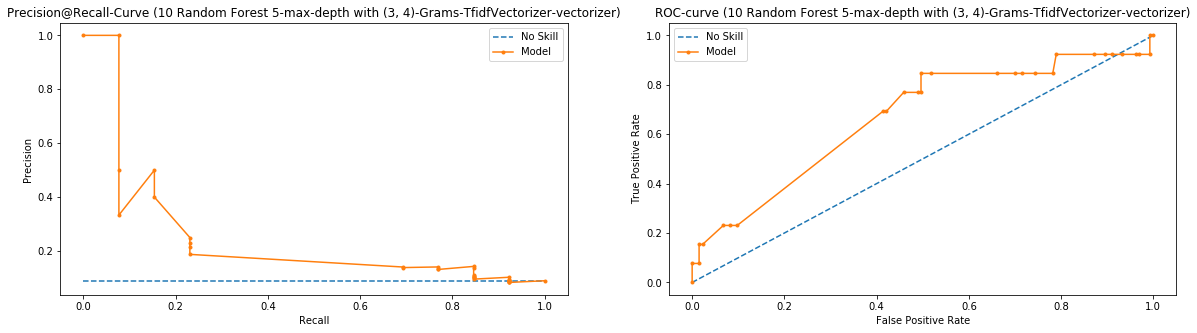

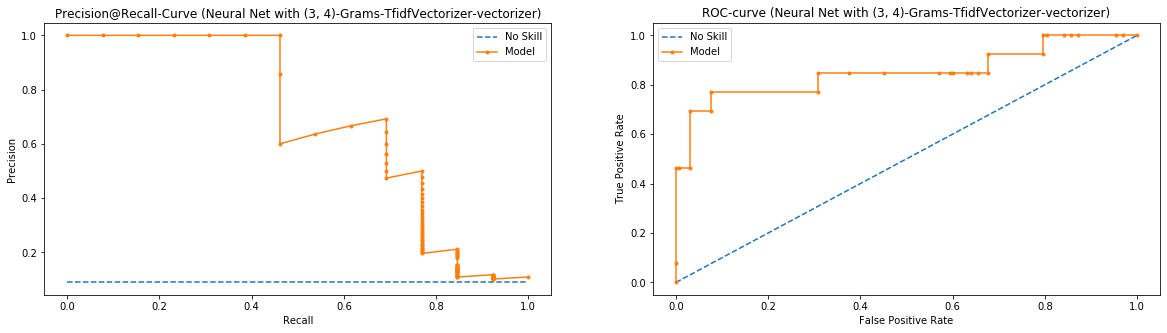

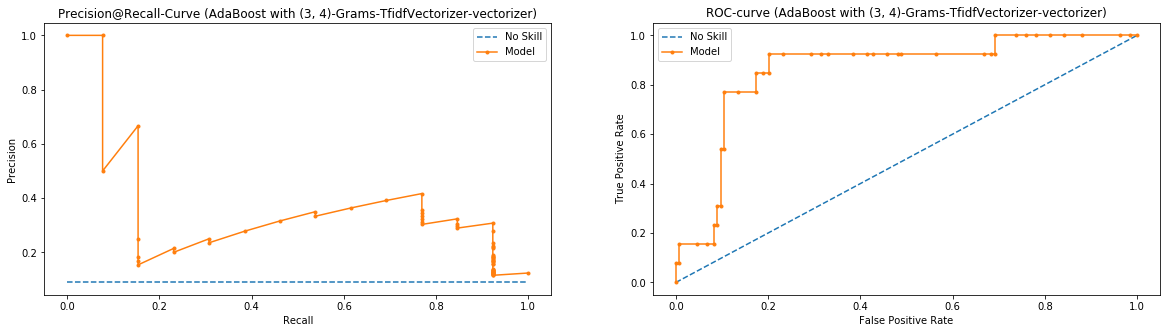

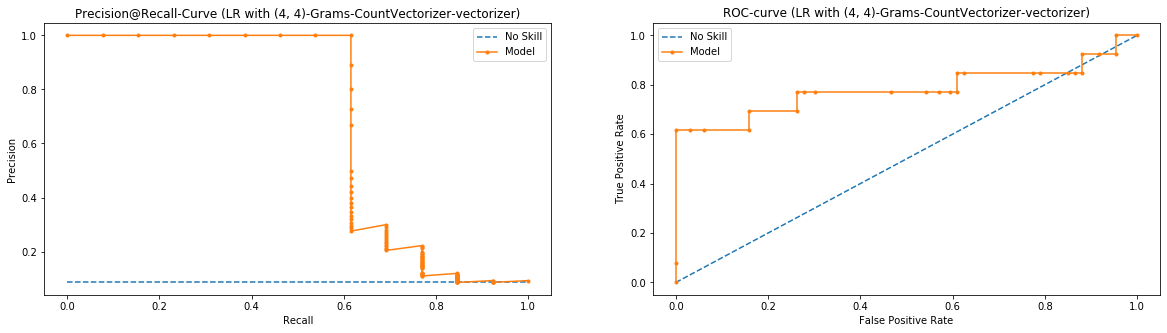

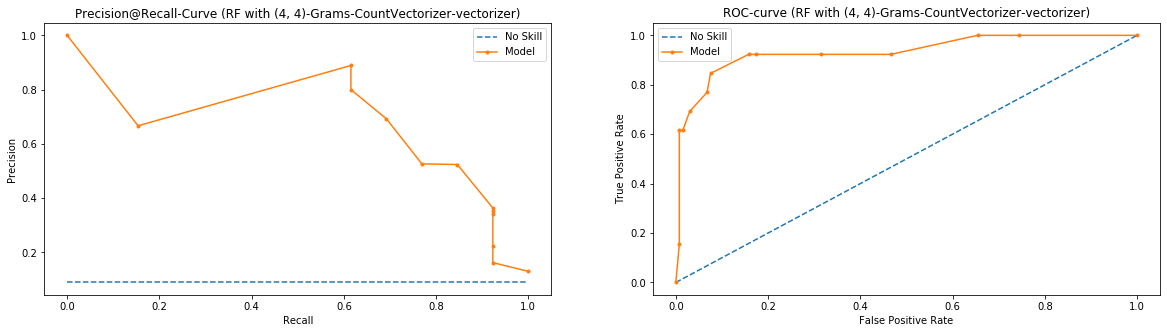

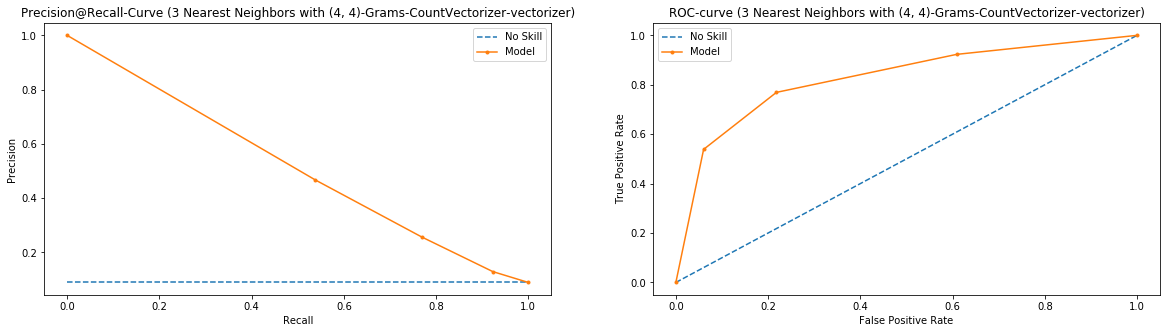

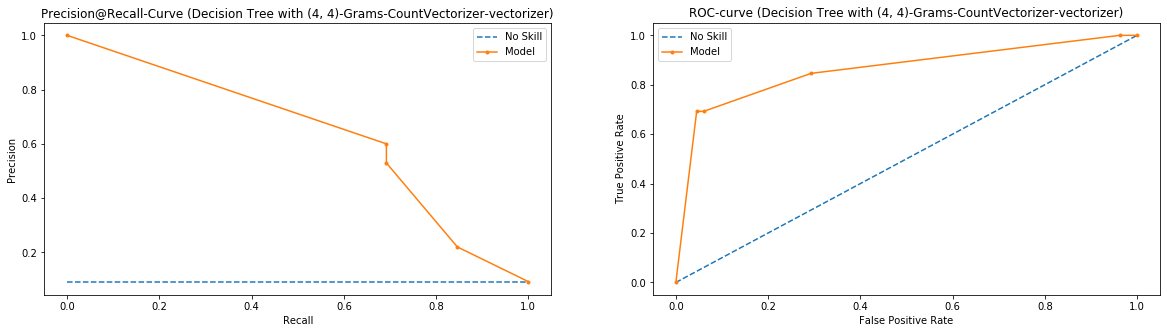

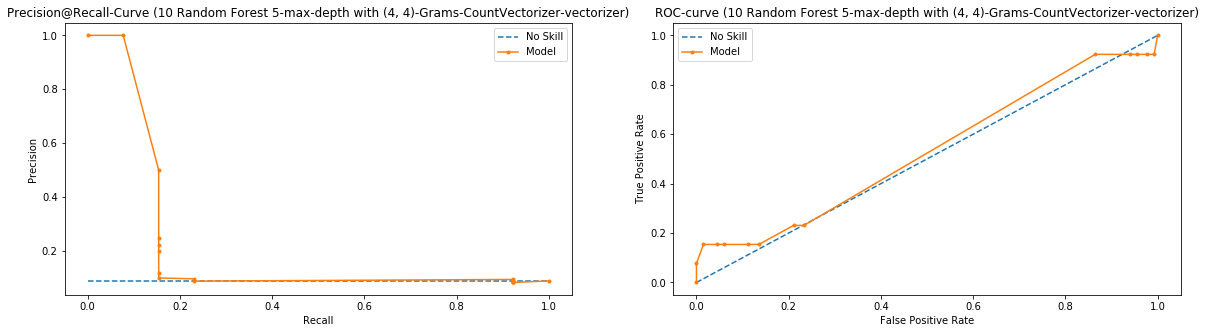

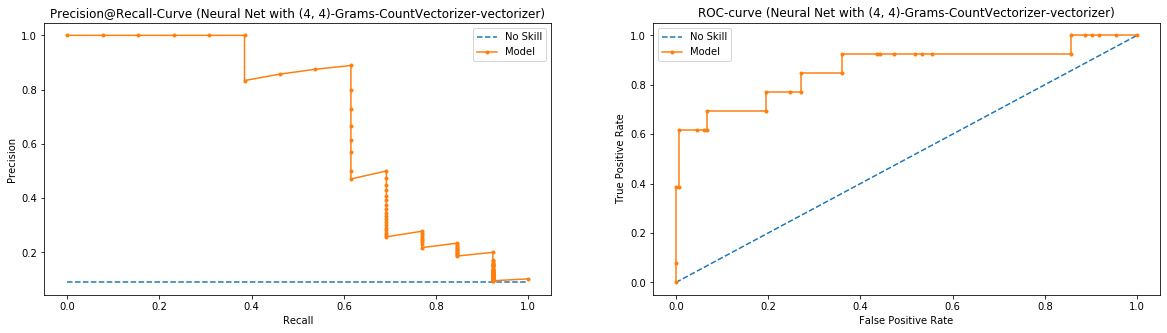

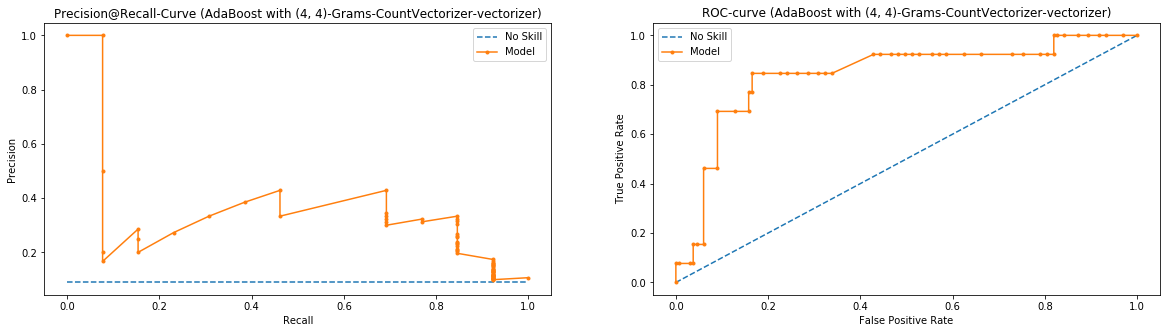

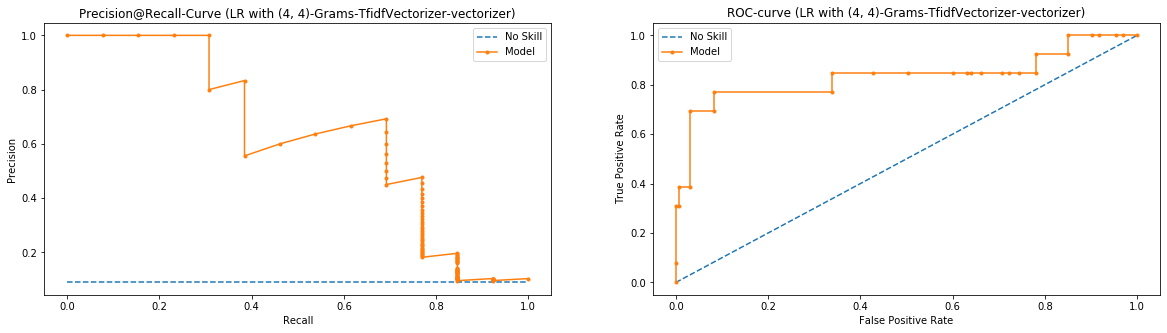

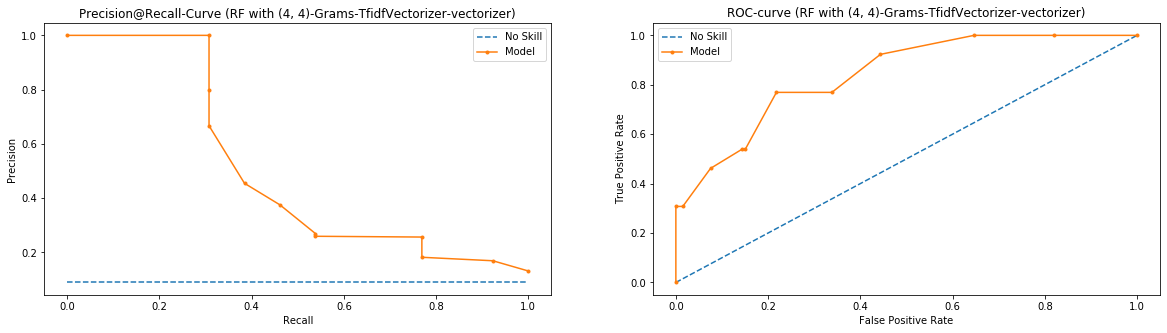

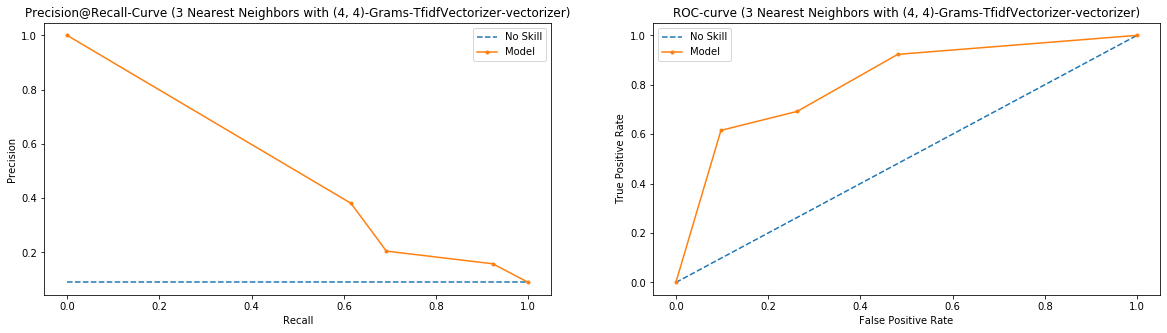

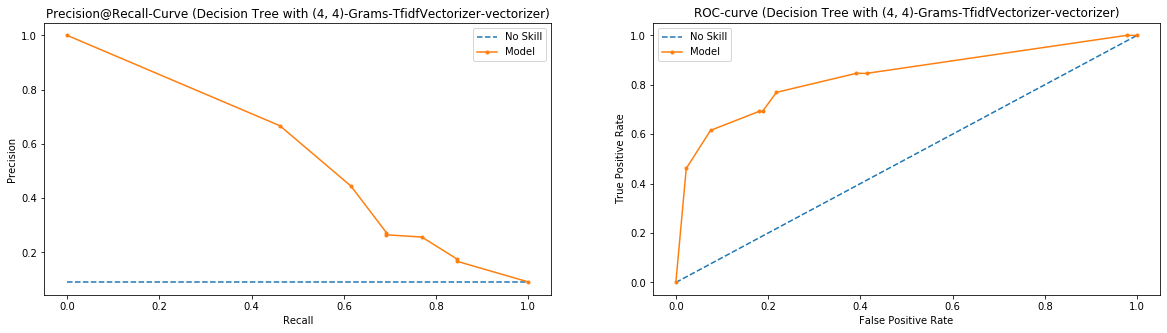

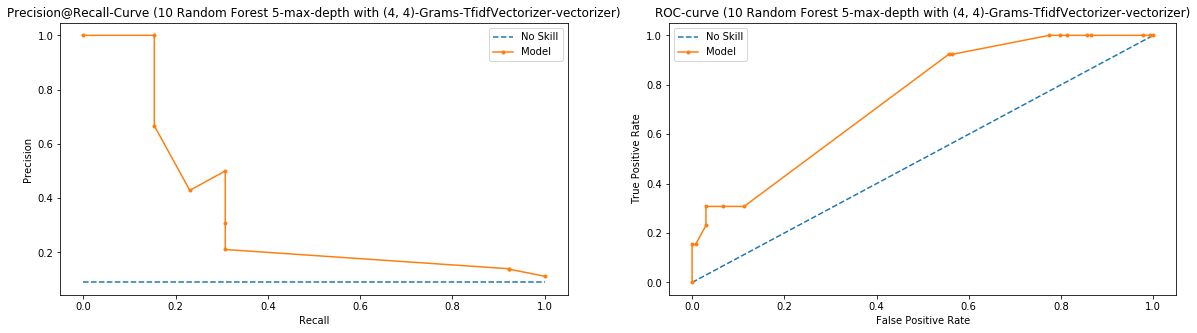

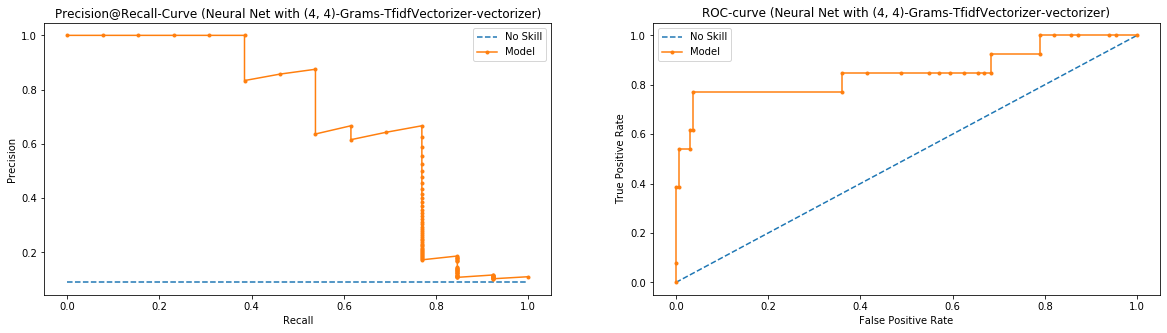

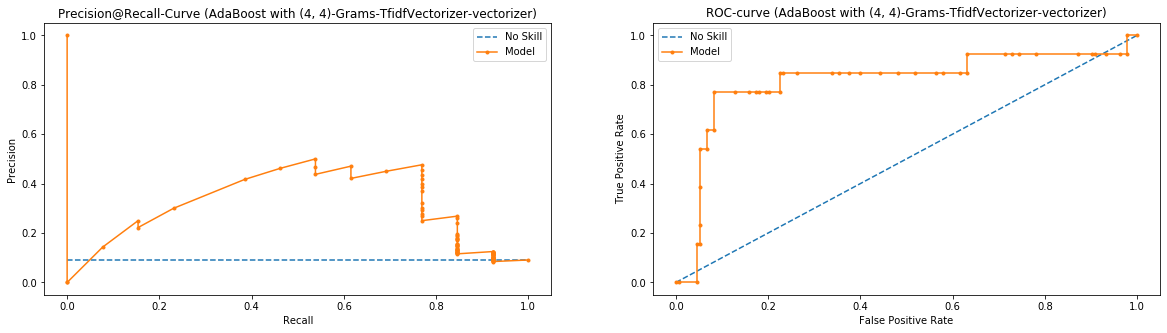

In [20]:
max_score = -1
winning_model = "none"
scoreboard_dict_list = []
metrics_dict_list = []

for ngram, ngram_name in ngrams_dict_list:
    for vectorizer, vectorizer_name in vectorizers_and_names_list:
        # create a count/tfidf vectorizer object 
        count_vect = vectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=ngram)
        count_vect.fit(train_x)
        
        # transform the training and test data using count vectorizer object
        xtrain_count =  count_vect.transform(train_x)
        xtest_count =  count_vect.transform(test_x)

        # build model
        for model_func, model_name in models_and_names_list:
            description = model_name + " with "  + ngram_name + "-" + vectorizer_name + "-vectorizer"
            print("model: " + description)
            print("\n")
            # run curves functionFleece
            metrics = train_test_model(model_func, description, xtrain_count, train_y, xtest_count, test_y)
            score = metrics['precision']
            if score > max_score:
                max_score = score
                winning_model = description
            score_dict = {}
            score_dict['model'] = description
            score_dict['score'] = score
            scoreboard_dict_list.append(score_dict)
            metrics_dict_list.append(metrics)
        
print("############################")
print("and the winner is........")
print(winning_model)
print("!!!!!!!!!!!!")
print("############################")




In [21]:
scoreboard_dict_list

[{'model': 'LR with (1, 1)-Grams-CountVectorizer-vectorizer', 'score': 0.25},
 {'model': 'RF with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.34615384615384615},
 {'model': '3 Nearest Neighbors with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.1694915254237288},
 {'model': 'Decision Tree with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.24444444444444444},
 {'model': '10 Random Forest 5-max-depth with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.20930232558139536},
 {'model': 'Neural Net with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.3125},
 {'model': 'AdaBoost with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.24324324324324326},
 {'model': 'LR with (1, 1)-Grams-TfidfVectorizer-vectorizer',
  'score': 0.1836734693877551},
 {'model': 'RF with (1, 1)-Grams-TfidfVectorizer-vectorizer',
  'score': 0.23529411764705882},
 {'model': '3 Nearest Neighbors with (1, 1)-Grams-TfidfVectorizer-vectorizer',
  'score': 0.23255813953488372

In [22]:
top_ten = sorted(scoreboard_dict_list, key=lambda d: d['score'], reverse=True)[0:10]

In [23]:
print("Top 10 models: (by precision metric)")



top_ten

Top 10 models: (by precision metric)


[{'model': '10 Random Forest 5-max-depth with (3, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.6666666666666666},
 {'model': 'RF with (2, 3)-Grams-CountVectorizer-vectorizer',
  'score': 0.5294117647058824},
 {'model': 'RF with (4, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.5238095238095238},
 {'model': 'RF with (2, 2)-Grams-CountVectorizer-vectorizer', 'score': 0.5},
 {'model': 'RF with (1, 4)-Grams-CountVectorizer-vectorizer', 'score': 0.5},
 {'model': 'Neural Net with (3, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.47619047619047616},
 {'model': '10 Random Forest 5-max-depth with (2, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.4666666666666667},
 {'model': 'RF with (1, 3)-Grams-CountVectorizer-vectorizer',
  'score': 0.46153846153846156},
 {'model': 'RF with (1, 2)-Grams-TfidfVectorizer-vectorizer',
  'score': 0.4583333333333333},
 {'model': 'Decision Tree with (2, 2)-Grams-TfidfVectorizer-vectorizer',
  'score': 0.45454545454545453}]

In [24]:
metrics_dict_list

[{'model': 'LR with (1, 1)-Grams-CountVectorizer-vectorizer',
  'precision': 0.25,
  'recall': 0.6153846153846154,
  'ROC_auc': 0.7565066512434934,
  'acc': 0.8013698630136986,
  'lr_PR_f1': 0.35555555555555557,
  'lr_PR_auc': 0.5275554156890525,
  'ns_auc': 0.5,
  'lr_auc': 0.7565066512434934},
 {'model': 'RF with (1, 1)-Grams-CountVectorizer-vectorizer',
  'precision': 0.34615384615384615,
  'recall': 0.6923076923076923,
  'ROC_auc': 0.8441295546558705,
  'acc': 0.8561643835616438,
  'lr_PR_f1': 0.46153846153846156,
  'lr_PR_auc': 0.5807306582744484,
  'ns_auc': 0.5,
  'lr_auc': 0.8441295546558705},
 {'model': '3 Nearest Neighbors with (1, 1)-Grams-CountVectorizer-vectorizer',
  'precision': 0.1694915254237288,
  'recall': 0.7692307692307693,
  'ROC_auc': 0.8076923076923077,
  'acc': 0.6438356164383562,
  'lr_PR_f1': 0.2777777777777778,
  'lr_PR_auc': 0.47475905933659224,
  'ns_auc': 0.5,
  'lr_auc': 0.8076923076923077},
 {'model': 'Decision Tree with (1, 1)-Grams-CountVectorizer-vec

# the end (:

In [25]:
import csv
with open(os.path.join(cuckoo_reports_dir_Path, "models_metrics.csv"), 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, metrics_dict_list[0].keys())
    w.writeheader()
    for metrics_dict in metrics_dict_list:
        w.writerow(metrics_dict)
